In [1]:
import pickle 
import json
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
from epiweeks import Week
import properscoring as ps
from datetime import datetime
from datetime import datetime
import matplotlib.pyplot as plt 
from train_models import LOOK_BACK, PREDICT_N 
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt 

import matplotlib.dates as mdates


In [2]:
PATH_LSTM = '../predictions/lstm'

## Functions 

### Skill score

In [3]:
def skill_score_mse(forecast, reference, target):
    '''
    Compute the skill score using the RMSE 
    '''
    
    rmse_f = mse(target, forecast, squared = False )
    
    rmse_r = mse(target, reference, squared = False)
    
    return 1 - (rmse_f/rmse_r)

### CRPS

In [4]:
def nearest_date_index(items, d):
    """
    Returns the index of the item in items which is nearest to the datetime d.
    """
    if isinstance(items[0], pd.Timestamp):
        items = [date.date() for date in items]
    time_diff = np.abs([date - d for date in items])
    return time_diff.argmin(0)

def compute_crps(file,  ini_evaluate = '2022-11-06',
                    end_evaluate = '2023-10-22'): 
    '''
    Function to compute the crps of the ensemble output of the DL models 
    between the two dates.
    '''
    cor_idx = LOOK_BACK+PREDICT_N-1
    with open(file, 'rb') as f:
        data = pickle.load(f)
    # df.iloc[df.index.get_loc(datetime.datetime(2016,2,2),method='nearest')]
    # Since the exact date may not be on the data, we need to find the nearest dates to the ones we want to evaluate
    ini_index= nearest_date_index(data['indice'], datetime.strptime(ini_evaluate, '%Y-%m-%d').date()) - cor_idx
    end_index = nearest_date_index(data['indice'], datetime.strptime(end_evaluate, '%Y-%m-%d').date()) - cor_idx
    #print (f"requested dates: {ini_evaluate} - {end_evaluate}, found dates: {data['indice'][ini_index+cor_idx]} - {data['indice'][end_index+cor_idx]}")
    # ini_index = data['indice'].index(datetime.strptime(ini_evaluate, '%Y-%m-%d').date()) - 55
    # end_index = data['indice'].index(datetime.strptime(end_evaluate, '%Y-%m-%d').date()) - 55

    ensemble = data['factor']*data['ensemble'][ini_index:end_index,-1, ]
    obs = data['factor']*data['target'][ini_index:end_index,-1]

    return ps.crps_ensemble(obs, ensemble).mean()



def skill(baseline_score, forecast_score):
    '''
    This function is used with the compute_crps to compute the skill using the crps metric 
    '''
    return (baseline_score - forecast_score) / baseline_score


### Get predictions

In [5]:
def get_preds(path = f'../../predictions/lstm/lstm_2211001_chik_predictions_msle.pkl', label = 'dengue_model', cor_idx= LOOK_BACK+PREDICT_N-1):
    '''
    Get the prediction from the lstm models and transform it in a dataframe. 
    '''
    with open(path, 'rb') as f:
        data = pickle.load(f)

    df = pd.DataFrame()
    
    df['date'] = data['indice'][cor_idx:]
    
    df[f'target_{label}'] = data['target'][:,-1]*data['factor']
    
    df[f'lower_{label}'] = data['lb'].iloc[:,-1]*data['factor']
    
    df[f'preds_{label}'] = data['pred'].iloc[:,-1]*data['factor']
    
    df[f'upper_{label}'] = data['ub'].iloc[:,-1]*data['factor']
    
    df.set_index('date',inplace = True)
    
    df.index = pd.to_datetime(df.index)
    
    return df


### Get data

In [6]:
def get_chik_data(city, ini_date = '2022-11-01', end_date = '2023-11-01'):
    '''
    Crate a single dataframe with all the lstm chik predictions: 
    * using the dengue model;
    * using the transf model; 
    * using the chik model. 
    '''
    
    d1 = get_preds(f'{PATH_LSTM}/lstm_{city}_chik_dengue_pred.pkl', label = 'dengue_model')
    
    d2 = get_preds(f'{PATH_LSTM}/lstm_{city}_chik_transf_pred.pkl', label = 'transf_model')

    d3 = get_preds(f'{PATH_LSTM}/lstm_{city}_chik_pred.pkl', label = 'chik_model')
    
    d = d1.merge(d2, left_index=True, right_index=True).merge(d3, 
    left_index=True, right_index=True)

    d['target'] = d['target_dengue_model']

    d = d.drop(['target_dengue_model', 'target_transf_model',
           'target_chik_model'], axis = 1)
    
    d = d.loc[ (d.index >= ini_date) & (d.index <= end_date )]

    return d


### Plot Comparisons

In [7]:
def make_bar_plot(ax, scores, label, min_v, max_v): 
    
    ind = ['dengue', 'chik']

    values = [ scores[label]['TL vs DL - dengue'], scores[label]['TL vs DL - chik']]
    
    
    ax.barh(ind, values, color=['tab:blue', 'tab:orange'],  align = 'center')
 
    ax.set_xlabel("SS")
    
    ax.set_ylabel('Model')

    ax.set_title(f'TL vs other models ({label})')
    
    ax.set_xlim([min_v, max_v])

    ax.invert_yaxis()

In [8]:
def plot_comp(ax, axbar1, axbar2, city, ini_evaluate = '2022-11-01', end_evaluate = '2023-10-01', model = 'DL'): 
    '''
    Function to compare the predictions in a given interval and compute the ss. 
    If the model is DL it's used the lstm model and is computed the skill score using crps 
    '''
    if model =='DL':
        df = get_chik_data(city, ini_date = ini_evaluate,
                             end_date = end_evaluate)
    if model == 'PGBM': 
        df = get_chik_data_pgbm(city, ini_date = ini_evaluate,
                             end_date = end_evaluate)
    
    ax.plot(df.index, df.target , color = 'black', label = 'Data', linewidth=2)

    ax.plot(df.index, df.preds_dengue_model, label = f'{model} - Dengue', color = 'tab:blue', ls = 'dashed', linewidth=2)

    ax.fill_between(df.index, df.lower_dengue_model,
                    df.upper_dengue_model,  color = 'tab:blue',
                    alpha = 0.2)


    ax.plot(df.index, df.preds_transf_model, label = f'TL', linewidth=2,
                        color = 'tab:red', ls = 'dashdot')

    ax.fill_between(df.index, df.lower_transf_model, 
                    df.upper_transf_model,
                        color = 'tab:red', alpha = 0.2)

    ax.set_xlabel('Date')

    ax.set_ylabel('New cases')

    ax.plot(df.index, df.preds_chik_model, label = f'{model} - Chik',color = 'tab:orange', ls = 'dotted', linewidth=2)

    ax.fill_between(df.index, df.lower_chik_model,
                   df.upper_chik_model, alpha = 0.2, color = 'tab:orange')
    
    
    myFmt = mdates.DateFormatter('%b\n%Y')
    ax.xaxis.set_major_formatter(myFmt)


    ax.grid()

    ax.legend()

    ax.set_title(f'Chikungunya forecasts at {city} ({model})')
    
    
    for tick in plt.gca().get_xticklabels():
        tick.set_rotation(20)
        
        
    scores = {}
    #print('Skill score using RMSE')
    
    scores['RMSE_SS'] = {
        'TL vs DL - dengue': skill_score_mse(forecast = df.preds_transf_model, 
                                            reference = df.preds_dengue_model, 
                                            target = df.target),
        'TL vs DL - chik': skill_score_mse(forecast = df.preds_transf_model, 
                                            reference = df.preds_chik_model, 
                                            target = df.target) 
    }
    #print('TL vs DL - dengue:', scores['RMSE_SS']['TL vs DL - dengue'])
    #print('TL vs DL - chik:', scores['RMSE_SS']['TL vs DL - chik'])
    
    if model == 'DL':
        
        #print('Skill score using CRPS')
        
        crps1 = compute_crps(f'{PATH_LSTM}/lstm_{city}_chik_dengue_pred.pkl',
                             ini_evaluate = ini_evaluate,
                             end_evaluate = end_evaluate)
    
        crps2 = compute_crps(f'{PATH_LSTM}/lstm_{city}_chik_transf_pred.pkl',
                            ini_evaluate = ini_evaluate,
                             end_evaluate = end_evaluate)

        crps3 = compute_crps(f'{PATH_LSTM}/lstm_{city}_chik_pred.pkl',
                            ini_evaluate = ini_evaluate,
                             end_evaluate = end_evaluate)
        scores['CRPS_SS'] = {
            'TL vs DL - dengue': skill(baseline_score = crps1, 
                                          forecast_score = crps2),
            'TL vs DL - chik': skill(baseline_score = crps3, 
                                          forecast_score = crps2)
        }
        #print('TL vs DL - dengue:', skill(baseline_score = crps1, 
         #                                 forecast_score = crps2))

        #print('TL vs DL - chik:', skill(baseline_score = crps3, 
          #                                forecast_score = crps2))
    
    
    min_v = min(0, scores['RMSE_SS']['TL vs DL - dengue'], 
                scores['RMSE_SS']['TL vs DL - chik'],
                scores['CRPS_SS']['TL vs DL - dengue'],
                scores['CRPS_SS']['TL vs DL - chik'])
    
    max_v = max(scores['RMSE_SS']['TL vs DL - dengue'], 
               scores['RMSE_SS']['TL vs DL - chik'],
               scores['CRPS_SS']['TL vs DL - dengue'],
               scores['CRPS_SS']['TL vs DL - chik'])
    
    
    
    #print( scores['RMSE_SS']['TL vs DL - dengue'])
    make_bar_plot(axbar1, scores, label = 'RMSE_SS', min_v = min_v -0.02 , max_v= max_v + 0.025)
    
    make_bar_plot(axbar2, scores, label = 'CRPS_SS', min_v = min_v - 0.02, max_v=max_v + 0.025)
    
    
    return

In [9]:
def gen_data_to_qq(city, ini_evaluate,end_evaluate):
    
    df_end = pd.DataFrame()
    
    df = get_chik_data(city, ini_date = ini_evaluate,
                             end_date = end_evaluate)


    df_end['dates'] = df.index
    df_end['dates'] = pd.to_datetime(df_end['dates'])
    df_end['week'] = [Week.fromdate(i).weektuple()[1] for i in df_end['dates']] 
    df_end['target_chik'] = df['target'].values
    df_end['preds_dl_dengue'] =  df['preds_dengue_model'].values
    
    df_end['preds_tl'] =  df['preds_chik_model'].values

    df_end['preds_dl_chik'] = df['preds_chik_model'].values
    
    # adicionando os dados de dengue: 
    
    df_dengue = pd.read_csv(f'../data/dengue_{city}_cluster.csv', index_col = 'Unnamed: 0' , usecols = ['Unnamed: 0', f'casos_{city}'])
    
    
    df_dengue.index = pd.to_datetime(df_dengue.index)
    
    df_dengue['week'] = [Week.fromdate(i).weektuple()[1] for i in df_dengue.index] 
    
    df_dengue['year'] = [Week.fromdate(i).weektuple()[0] for i in df_dengue.index]
    
    #adicionando data faltando 
    
    v = ( df_dengue.loc['2018-04-01'][f'casos_{city}'] + df_dengue.loc['2018-04-15'][f'casos_{city}'] )/2
    
    f = {f'casos_{city}':v, 'week':15 , 'year':2018}
    
    
    s = pd.DataFrame(f, index=['2018-04-08'])
    
    # df_dengue = df_dengue.append(s)
    df_dengue = pd.concat([df_dengue, s], axis=0)
 
    df_dengue.index = pd.to_datetime(df_dengue.index)
    
    df_dengue = df_dengue.sort_index()
    
    
    for y in np.arange(2010, max(df_end.dates.dt.year)):
        
        df_s = df_dengue.loc[df_dengue.year == y]
        
        try:

            df_end[f'dengue_{y}'] = df_s.loc[ df_s.week.isin(df_end.week)][f'casos_{city}'].values
            
        except:
                        
            print('Erro para o ano:')
            print(y)
    


    
    return df_end

def plot_cross_qq(ax, q_o, q_p, title):
    sns.kdeplot(x = q_o[len(q_p) - len(q_o):], y = q_p, ax =ax, fill = True)
    ax.set_xlabel('observed')
    ax.set_ylabel('predicted')
    
    max_v = max( max(q_p), max(q_o))
    
    ax.set_xlim([0, max_v])
    ax.set_ylim([0, max_v])
    ax.plot([0, 100], [0, 100], 'k')
    
    ax.set_title(f'{title} - p.25: {round(np.percentile(q_p - q_o, 25),2)} - p.50: {round(np.median(q_p - q_o), 2)} - p.75: {round(np.percentile(q_p - q_o, 75), 2)}')
    #P.title(f'Transfer prediction percentiles with {model_name.lower()} for {doenca} at {city_name}')

def gen_qq_plot(ax,city, ini_evaluate, end_evaluate, plot=True):
    
    df =  gen_data_to_qq(city, ini_evaluate, end_evaluate)
    
    cols = df.columns[ df.columns.str.startswith('dengue')]
    
    obs_preds = df[cols].values

    chik = df['target_chik'].values

    pred_tl = df['preds_tl'].values

    pred_dl_dengue = df['preds_dl_dengue'].values
    
    pred_dl_chik = df['preds_dl_chik'].values

    q_o = ss.percentileofscore(obs_preds, chik)

    q_p_dl_dengue = ss.percentileofscore(obs_preds, pred_dl_dengue)
    
    q_p_dl_chik = ss.percentileofscore(obs_preds, pred_dl_chik)

    q_p_tl = ss.percentileofscore(obs_preds, pred_tl)
    
    plot_cross_qq(ax[0], q_o, q_p_tl, title = 'TL')

    plot_cross_qq(ax[1], q_o, q_p_dl_dengue, title = 'DL - dengue')
    
    plot_cross_qq(ax[2], q_o, q_p_dl_dengue, title = 'DL - chik')
    plt.tight_layout()
    
    #plt.savefig(f'../figures/qq_plot_{city}.png', dpi = 300, bbox_inches = 'tight')
    
    
    return


In [17]:
def gen_summary(city, ini_evaluate, end_evaluate): 
    
    fig, axs = plt.subplot_mosaic([['a)', 'a)', 'b)'], ['a)', 'a)', 'c)'], ['d)', 'e)', 'f)']],
                              layout='constrained', figsize = (12,10))

    plot_comp(axs['a)'], axs['b)'], axs['c)'], city, ini_evaluate = ini_evaluate, end_evaluate = end_evaluate, model = 'DL')


    gen_qq_plot(ax=[axs['d)'], axs['e)'], axs['f)']], city = city, ini_evaluate = ini_evaluate, end_evaluate = end_evaluate)
    
    fig.suptitle(f'City - {city}', y = 1.01, fontsize=12)
        
    plt.savefig(f'../figures/summary_{city}.png', dpi = 300, bbox_inches = 'tight')
    
    plt.show()
    

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


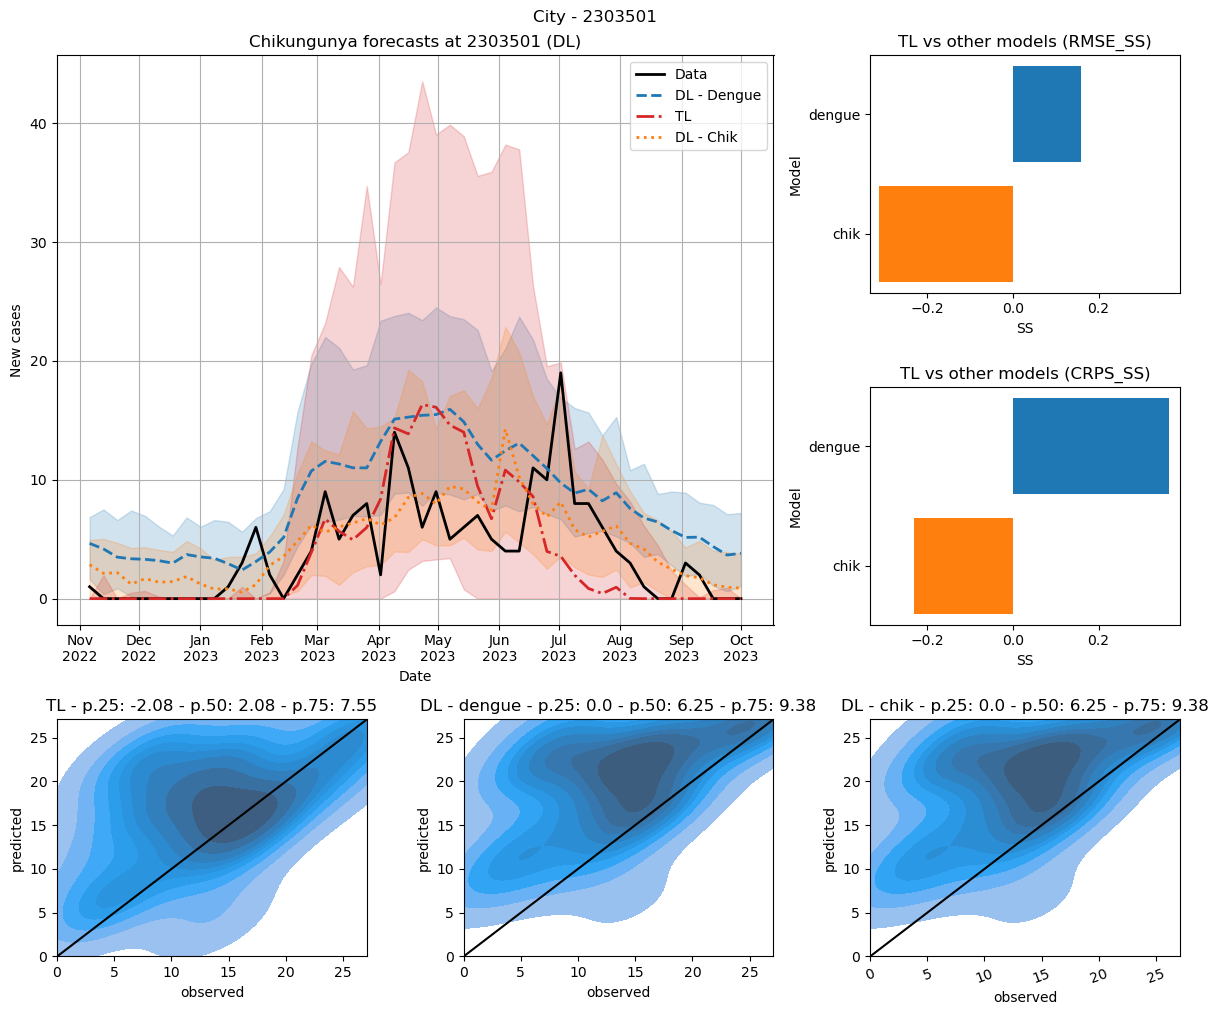

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


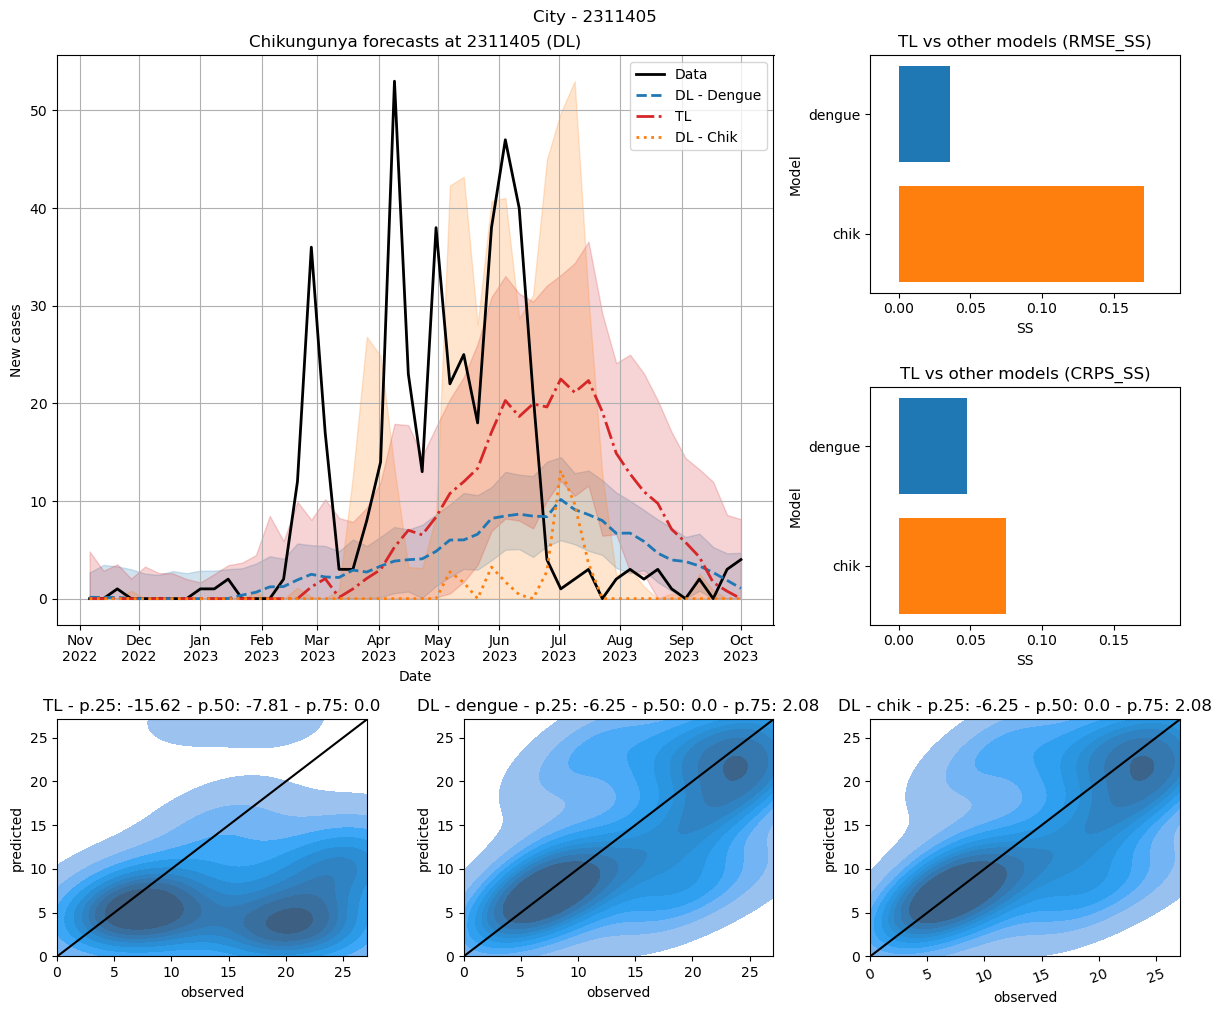

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


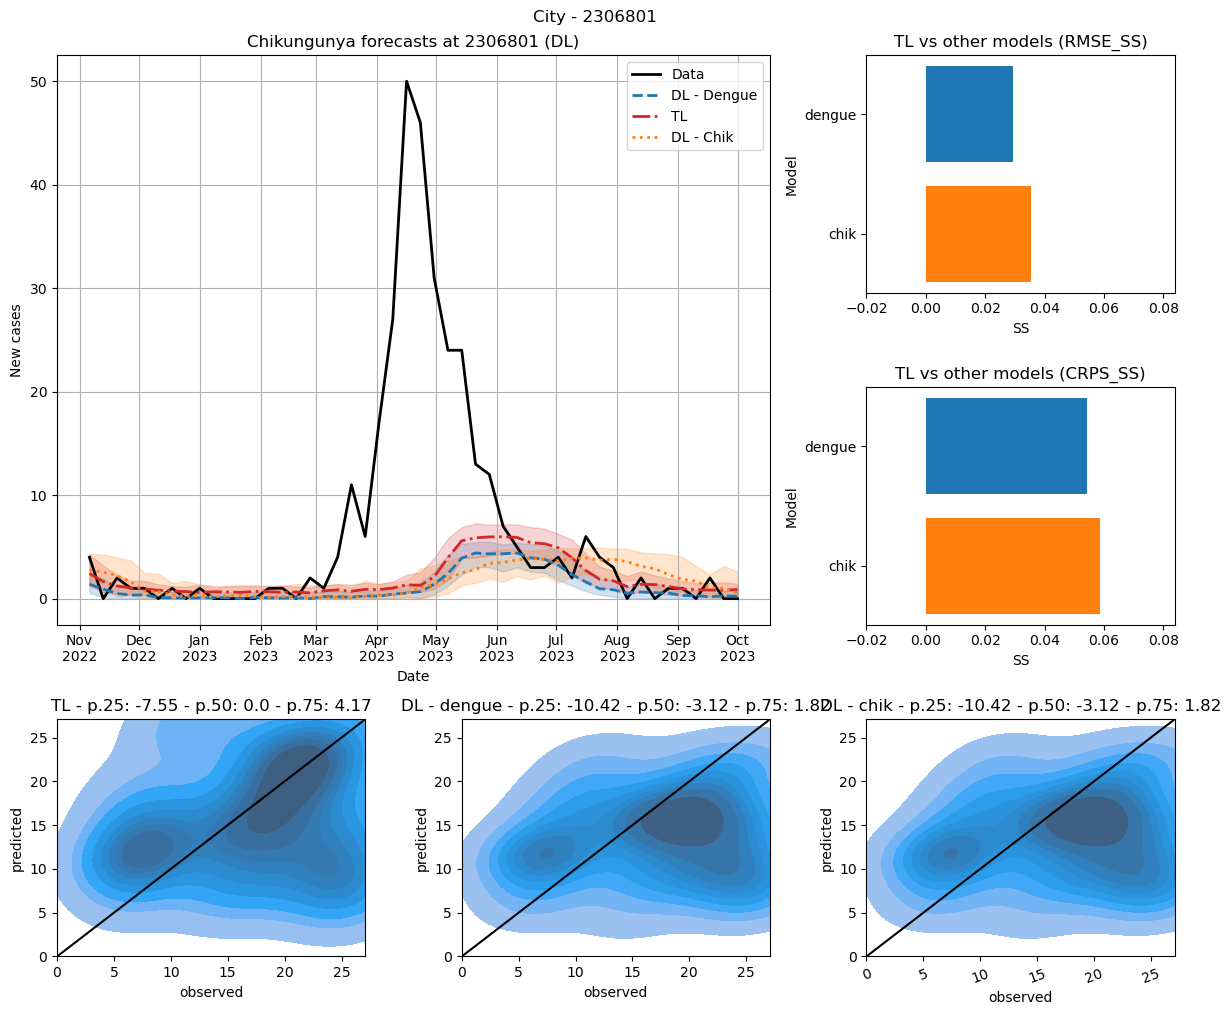

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


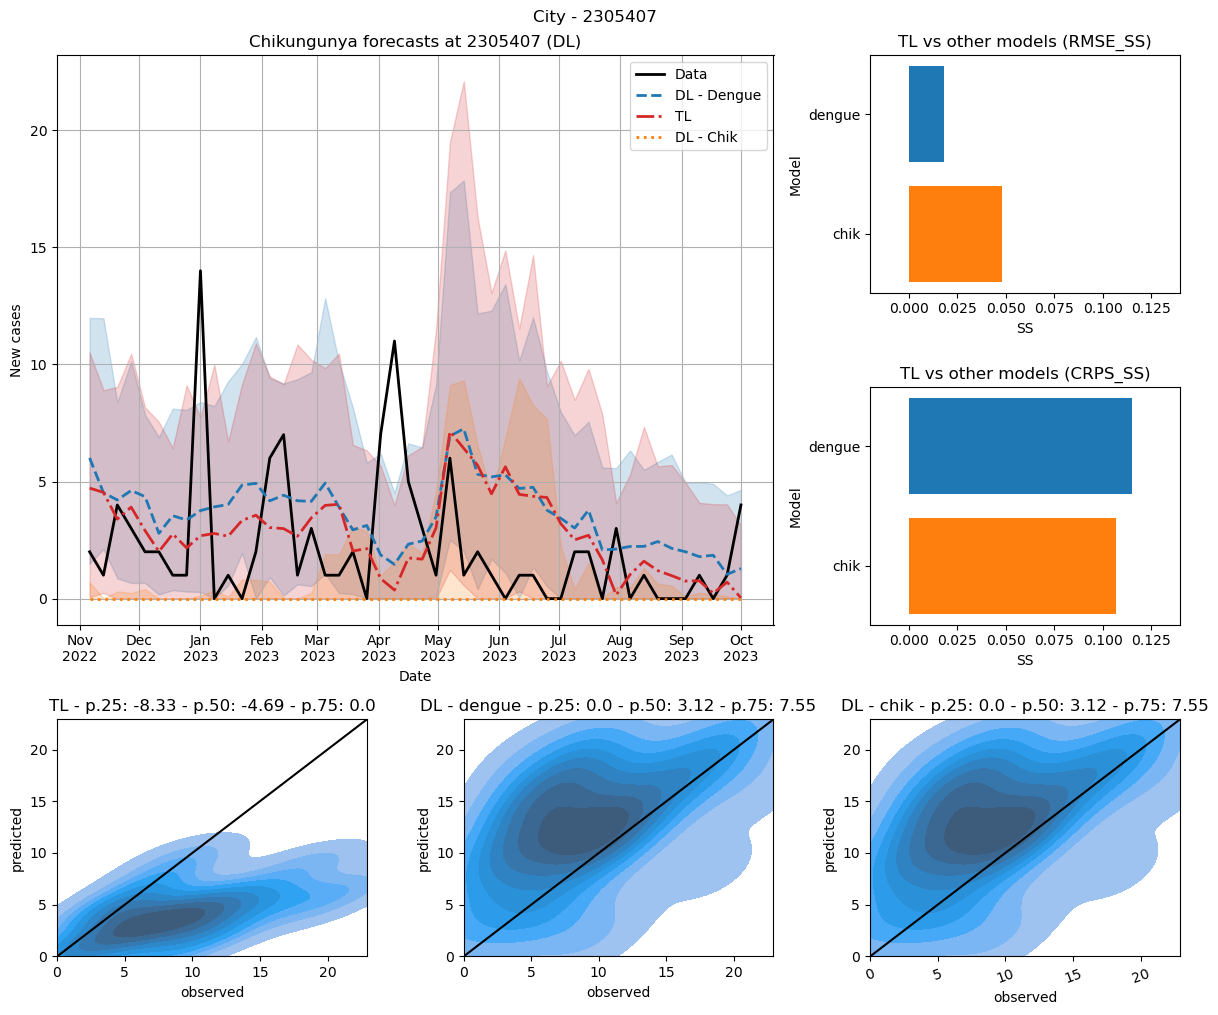

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


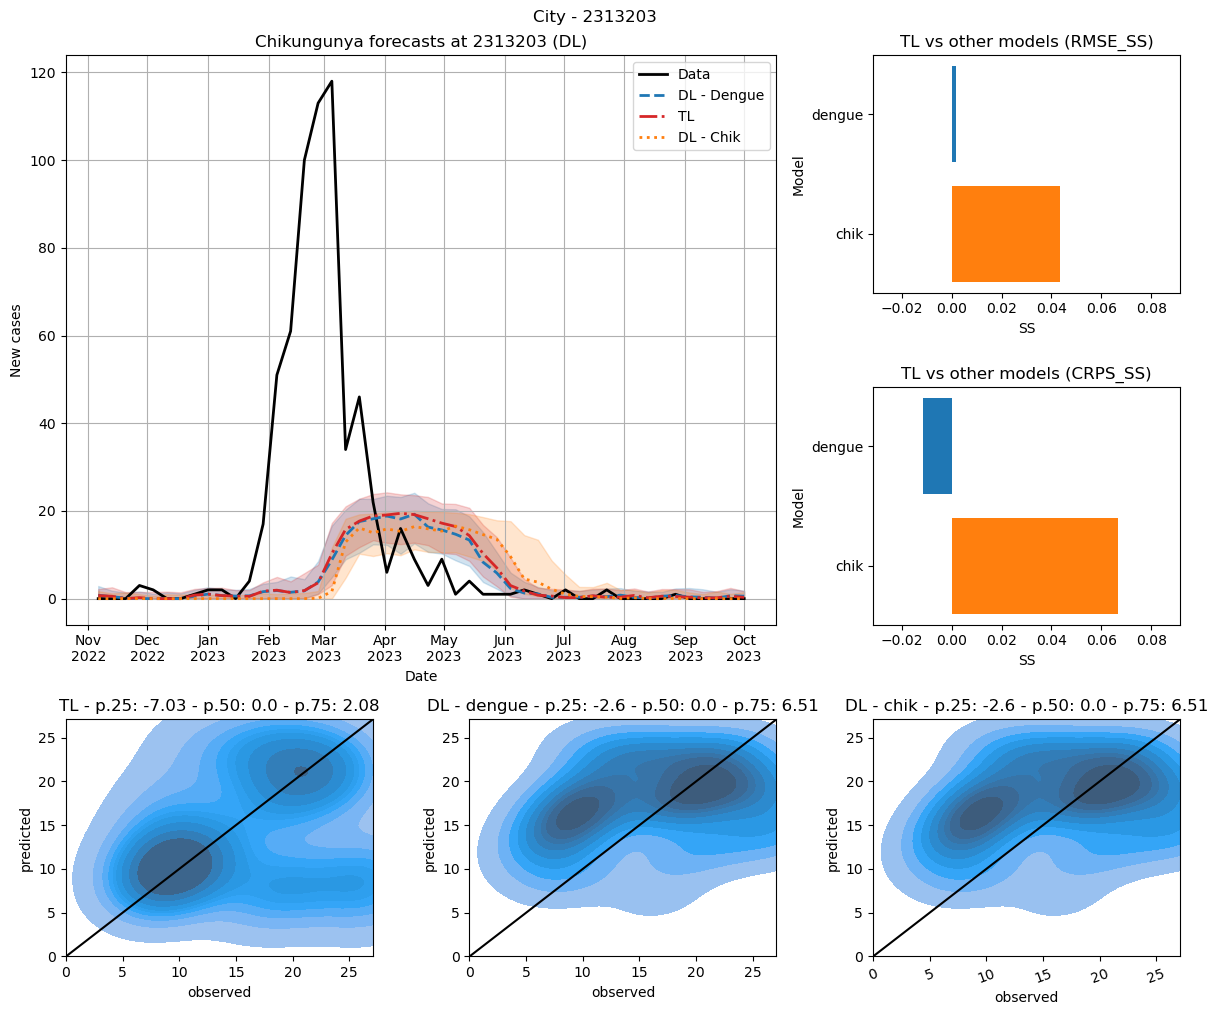

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


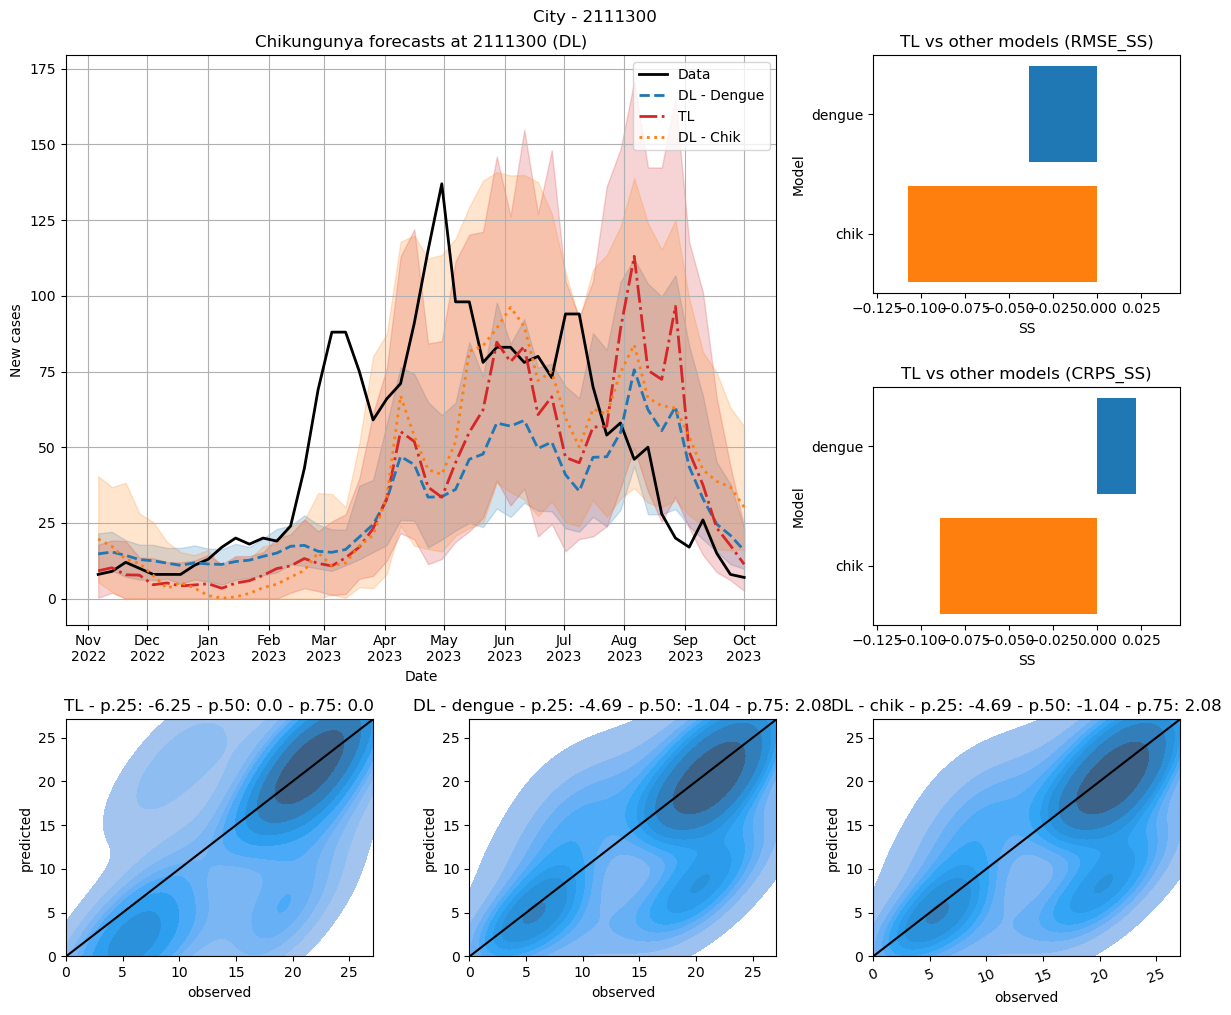

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


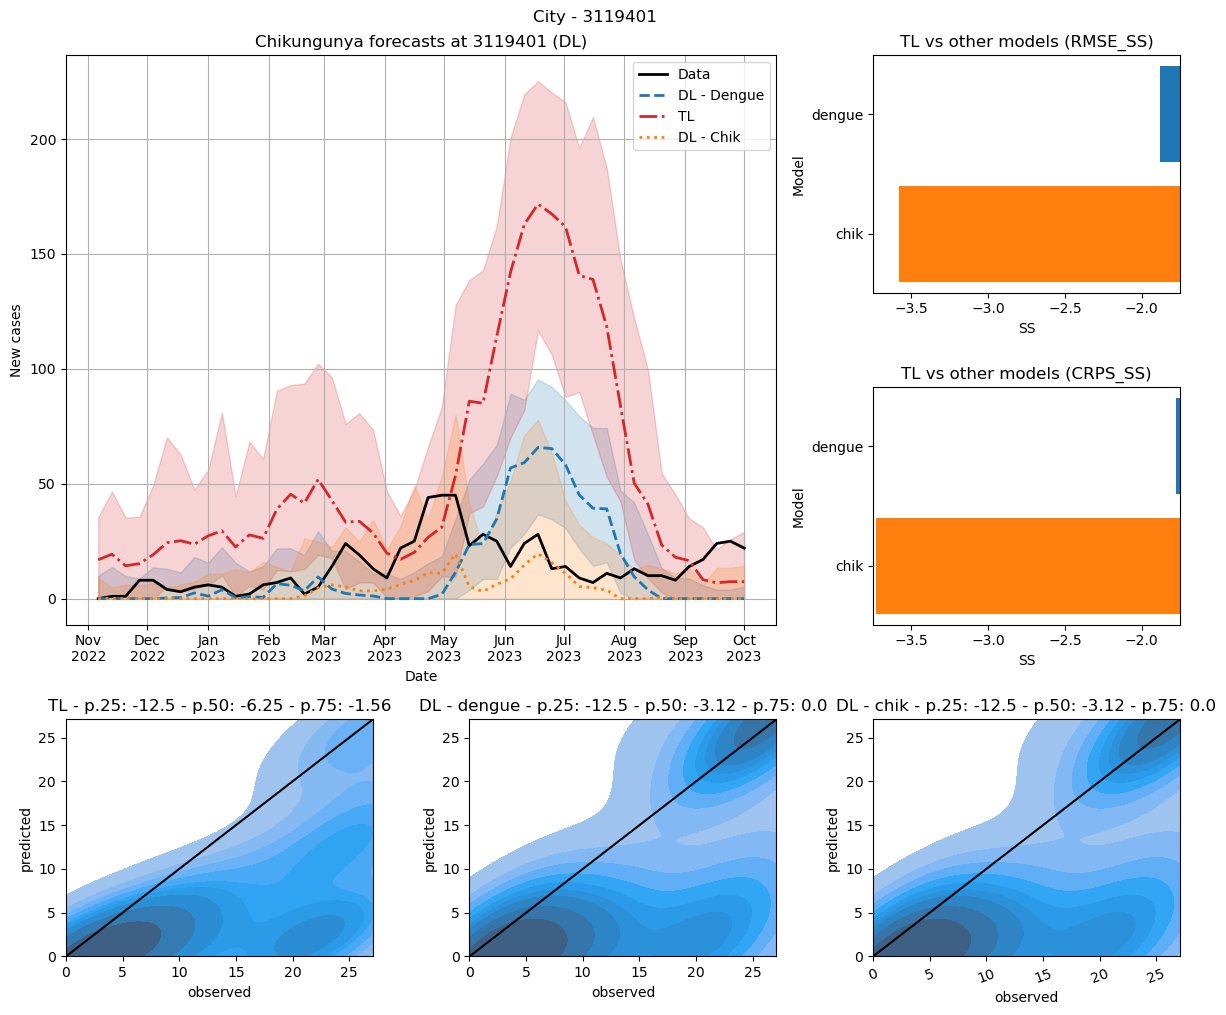

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


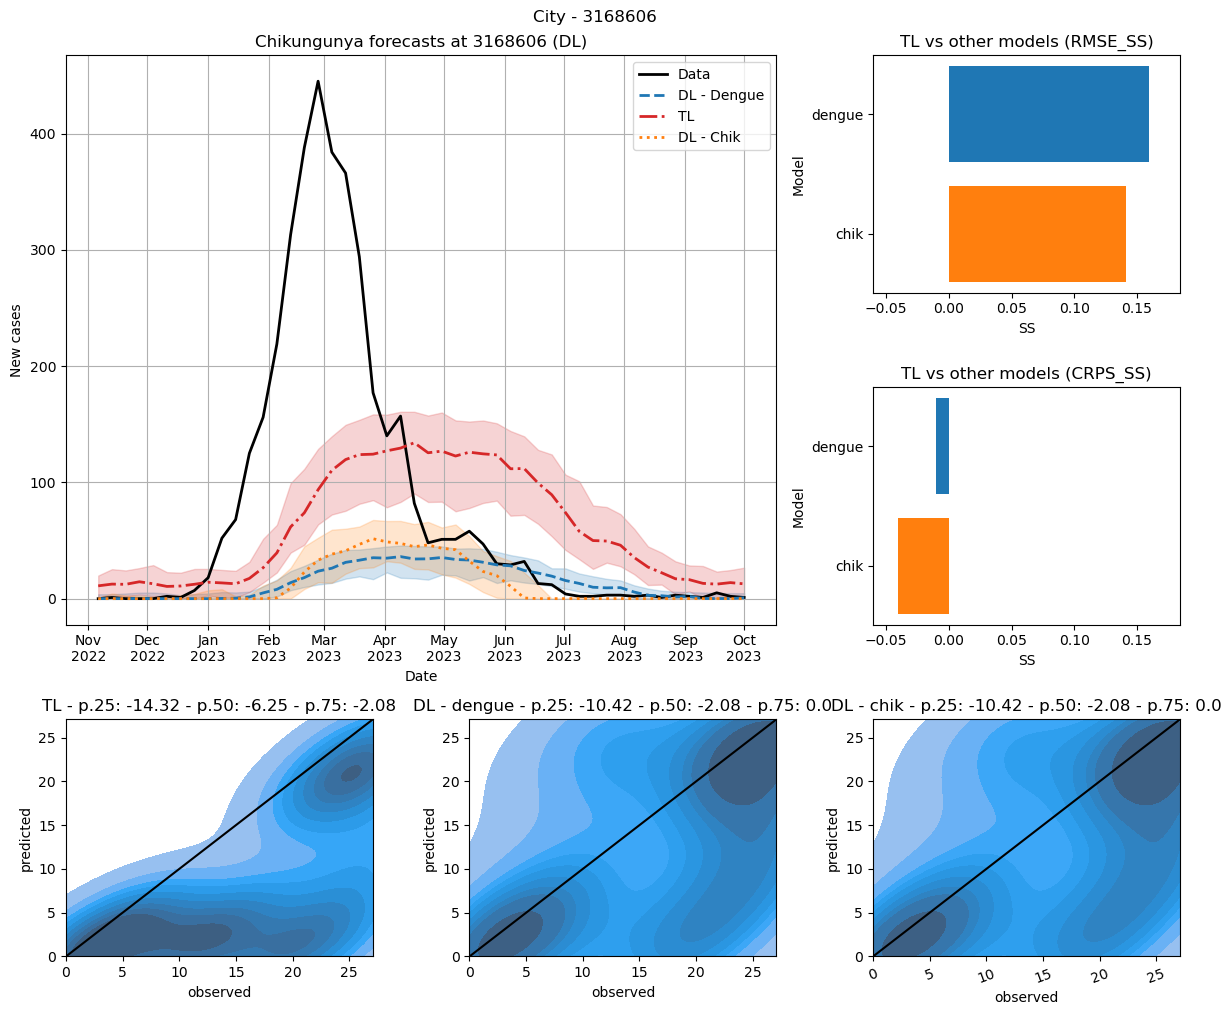

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


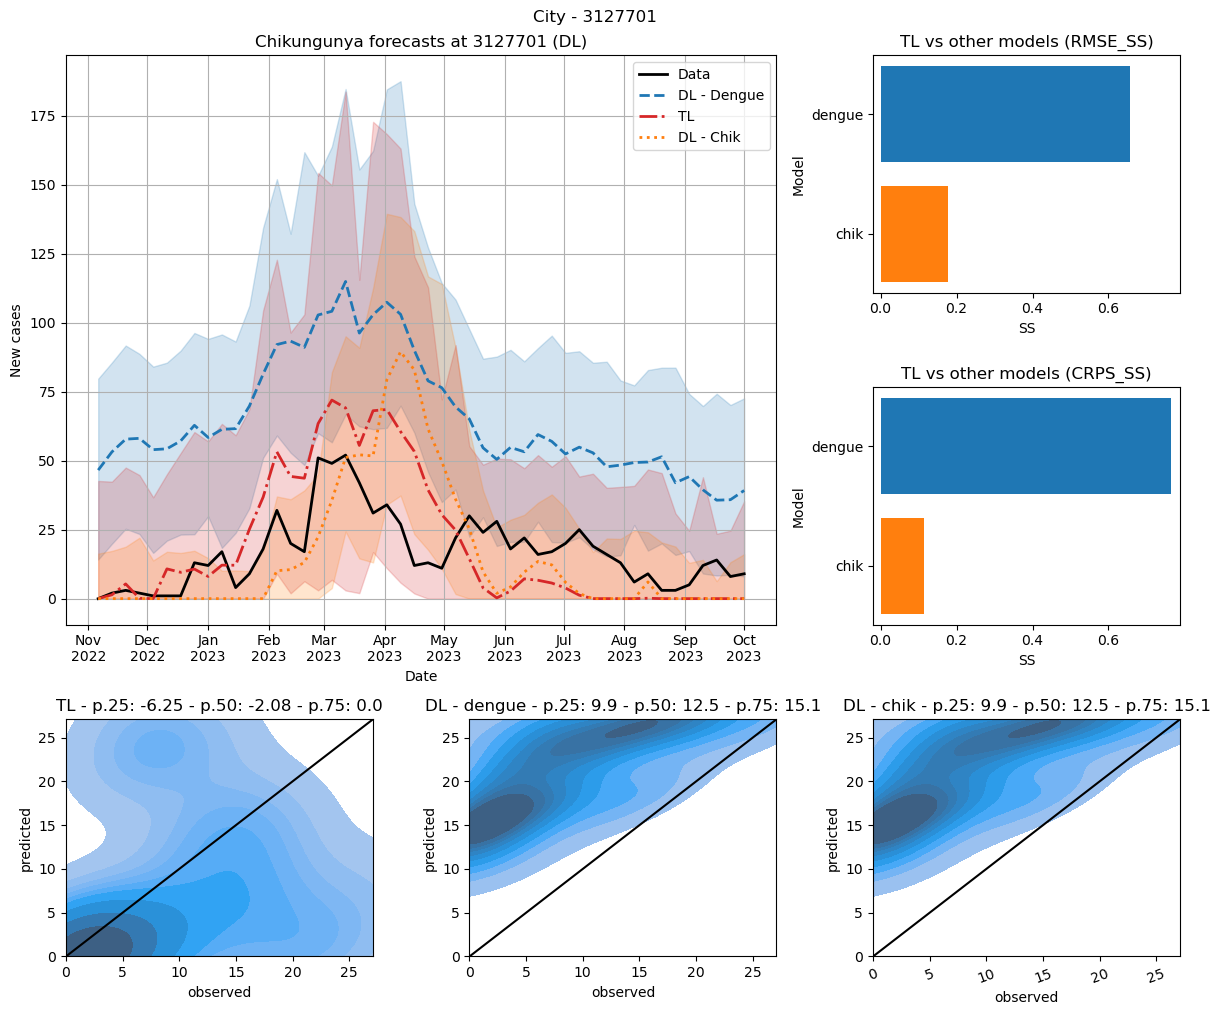

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


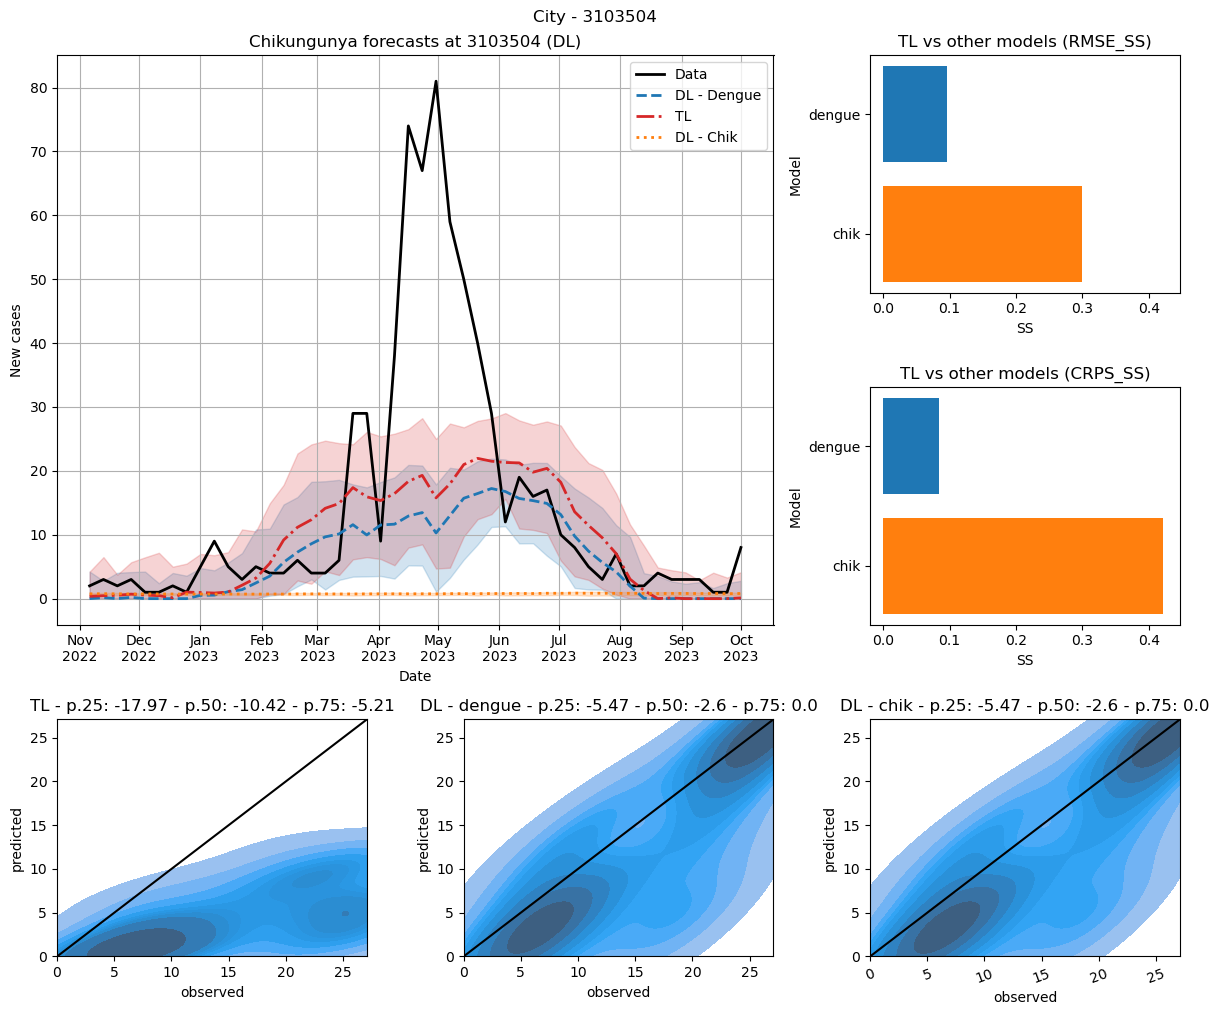

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


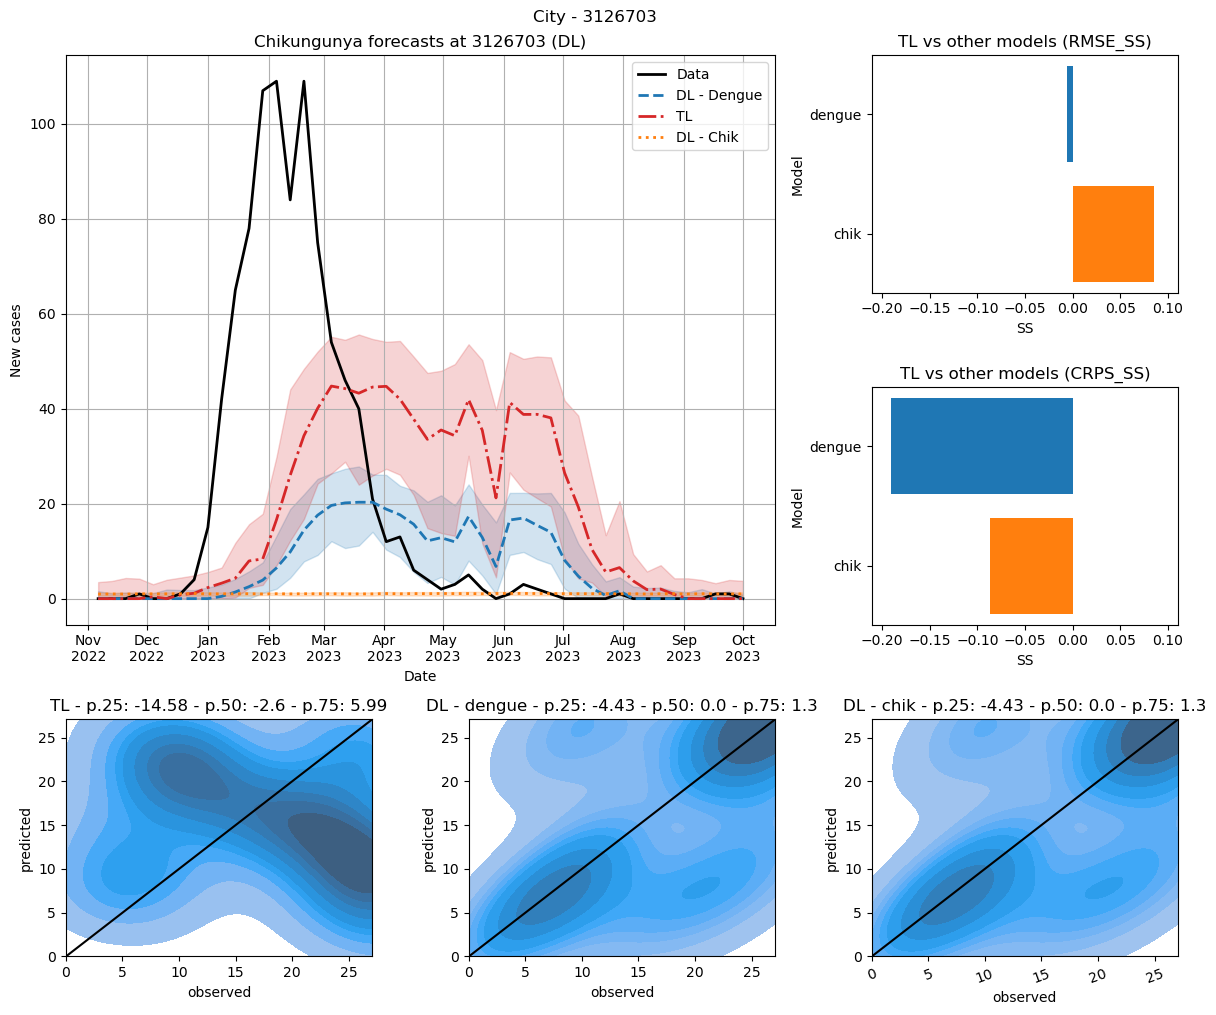

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


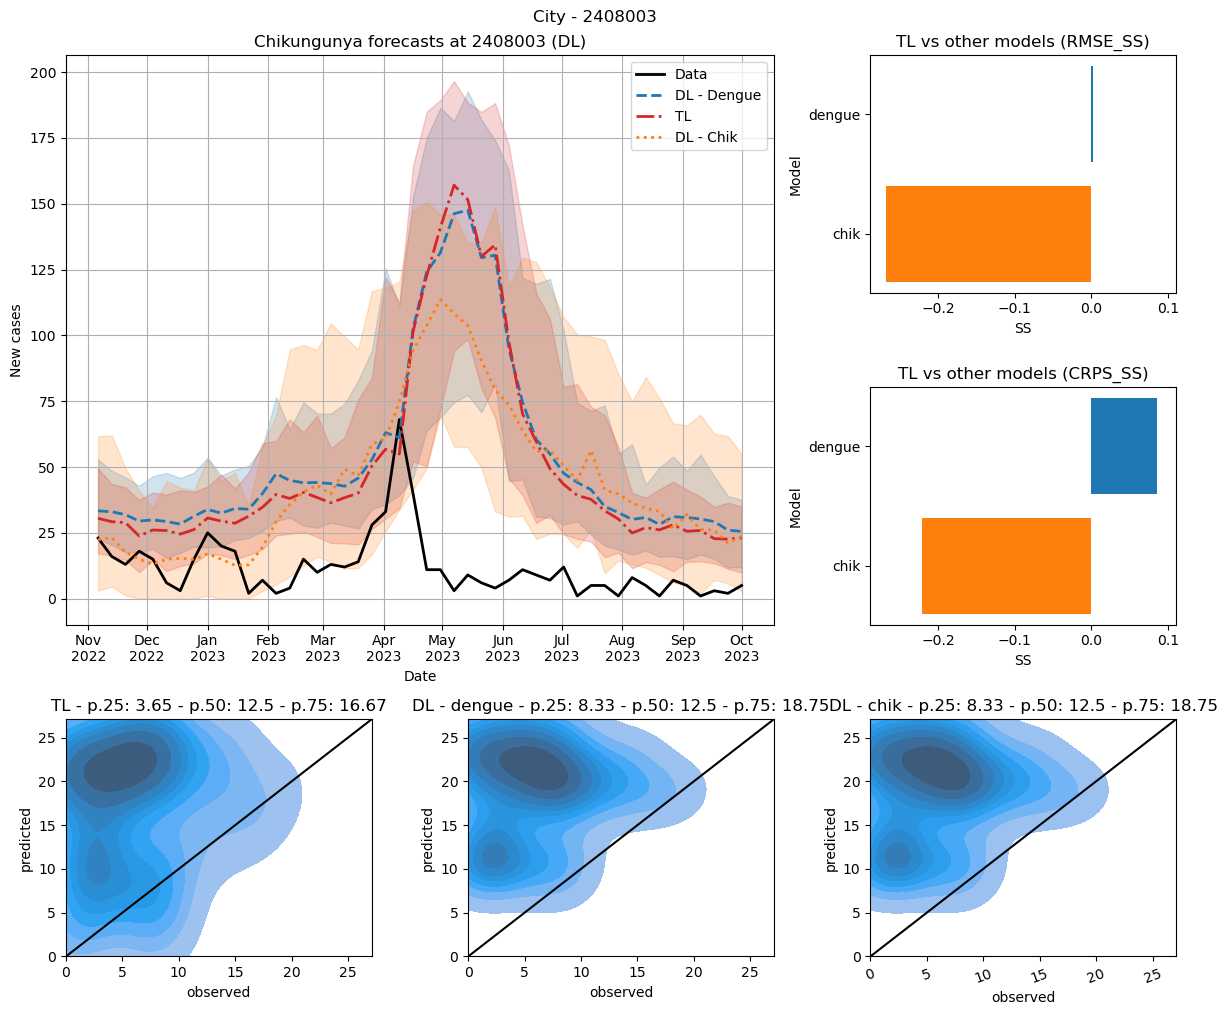

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


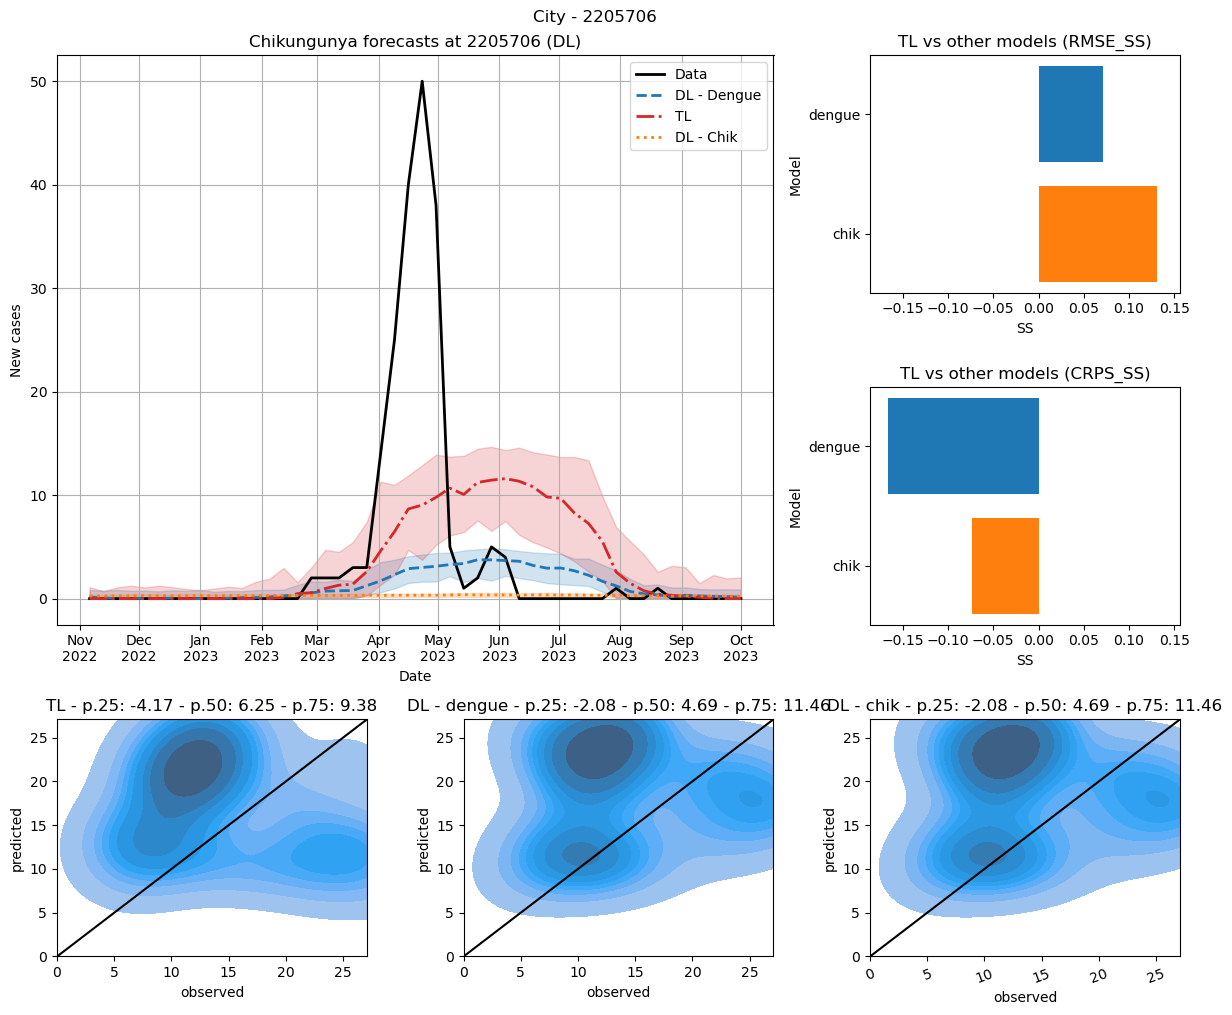

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


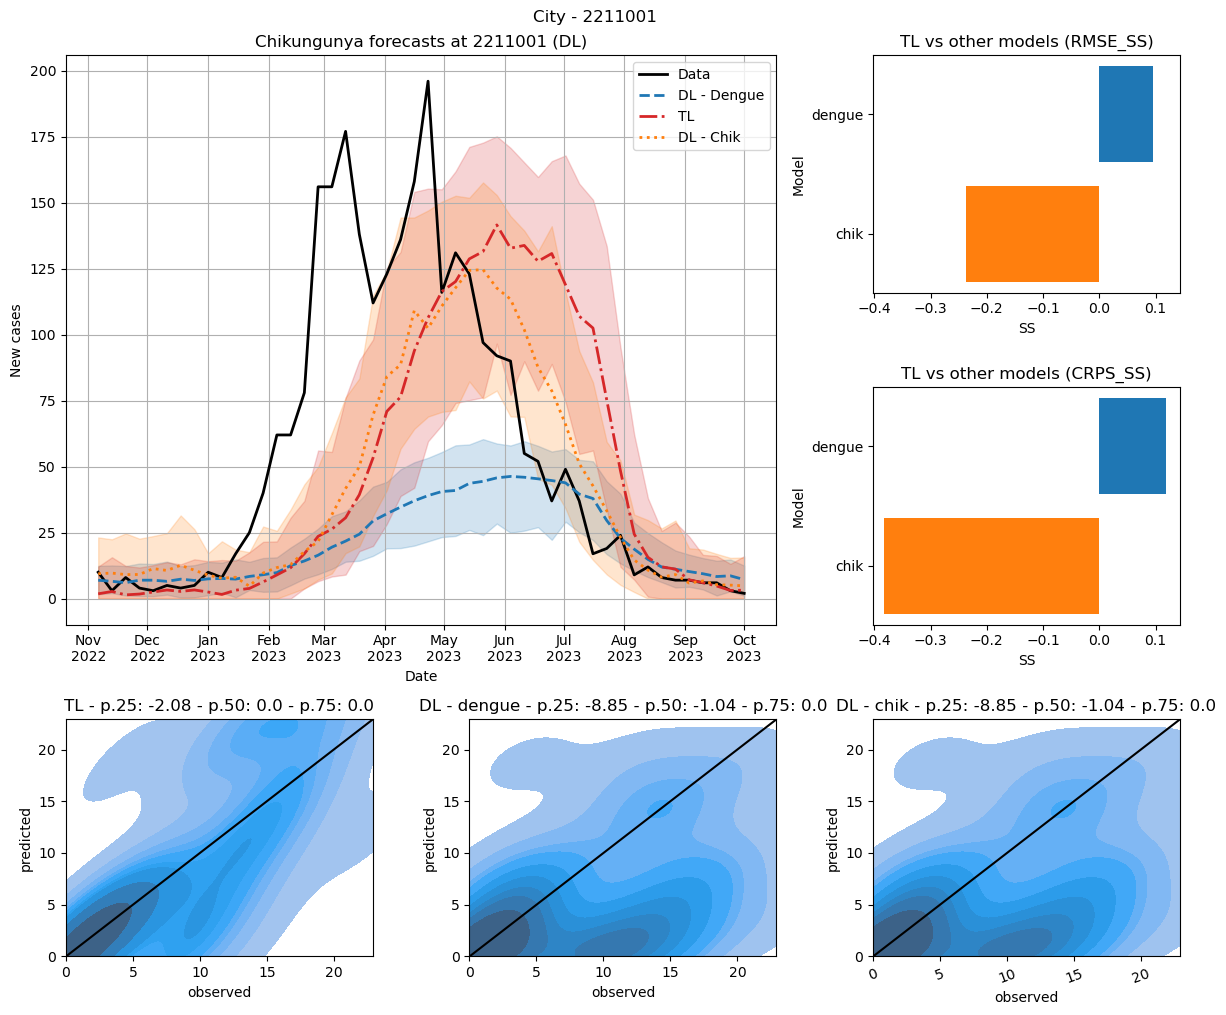

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


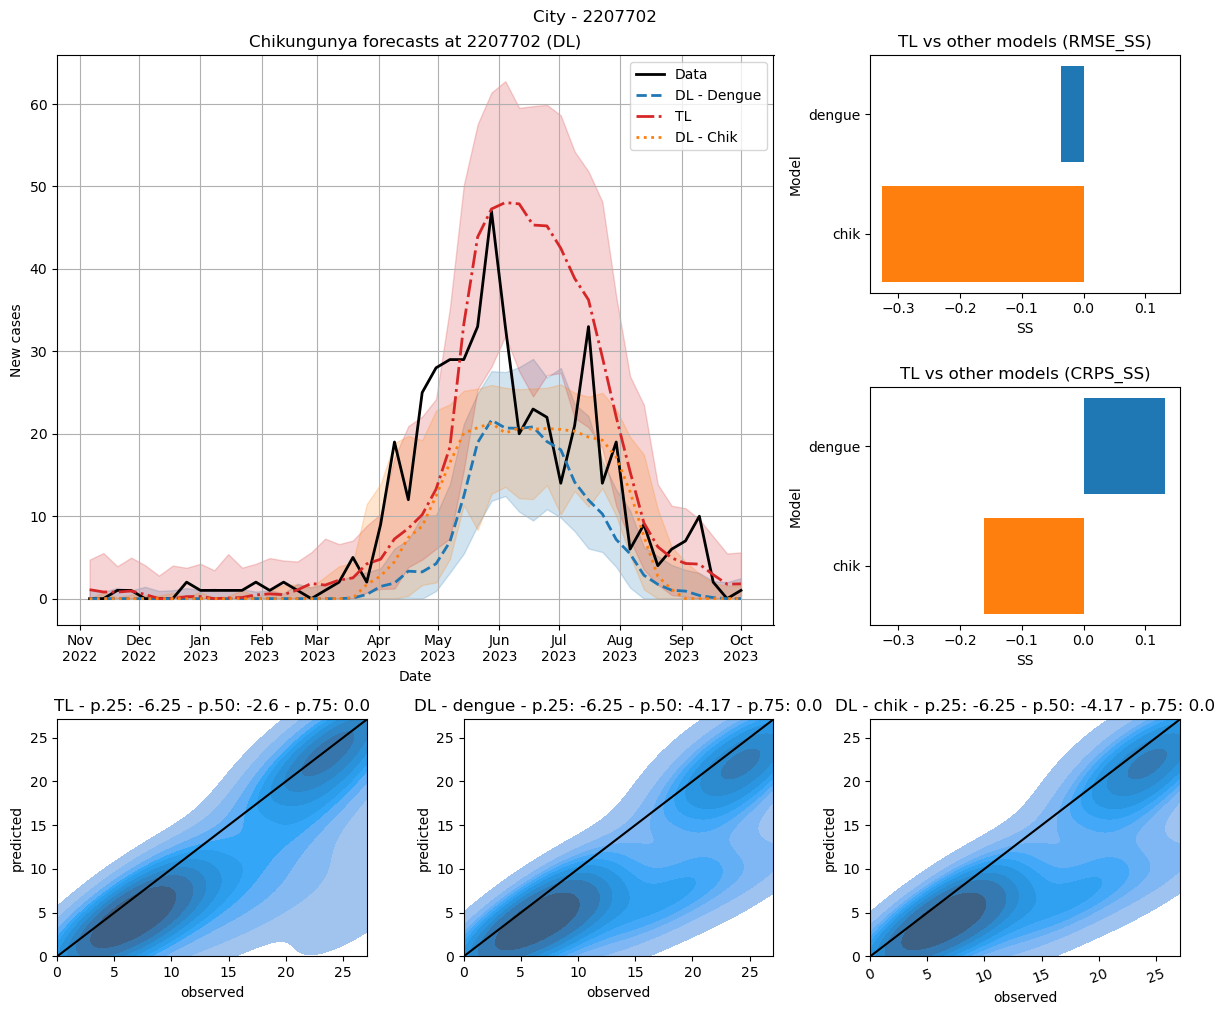

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


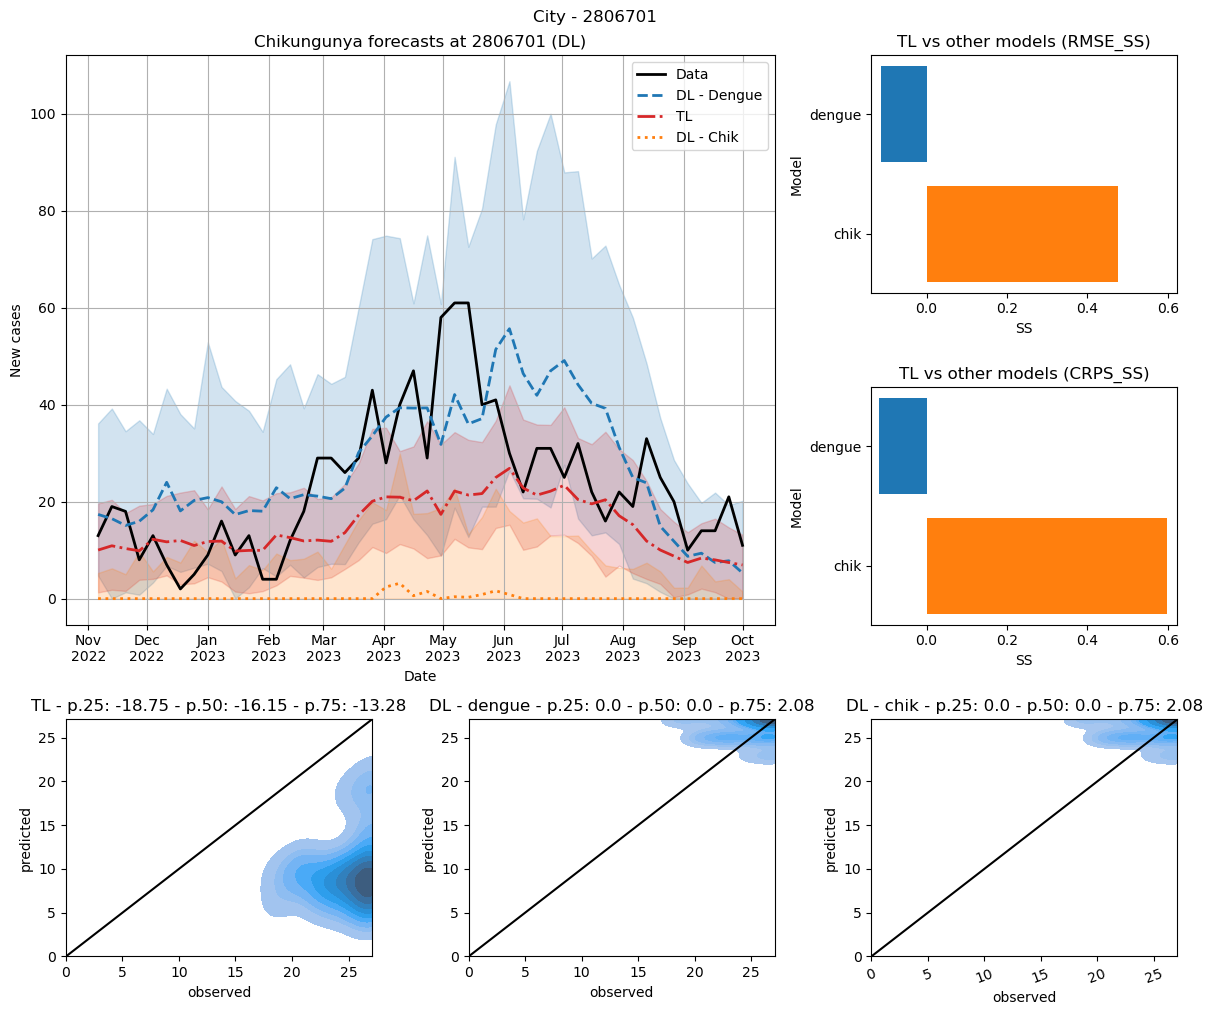

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


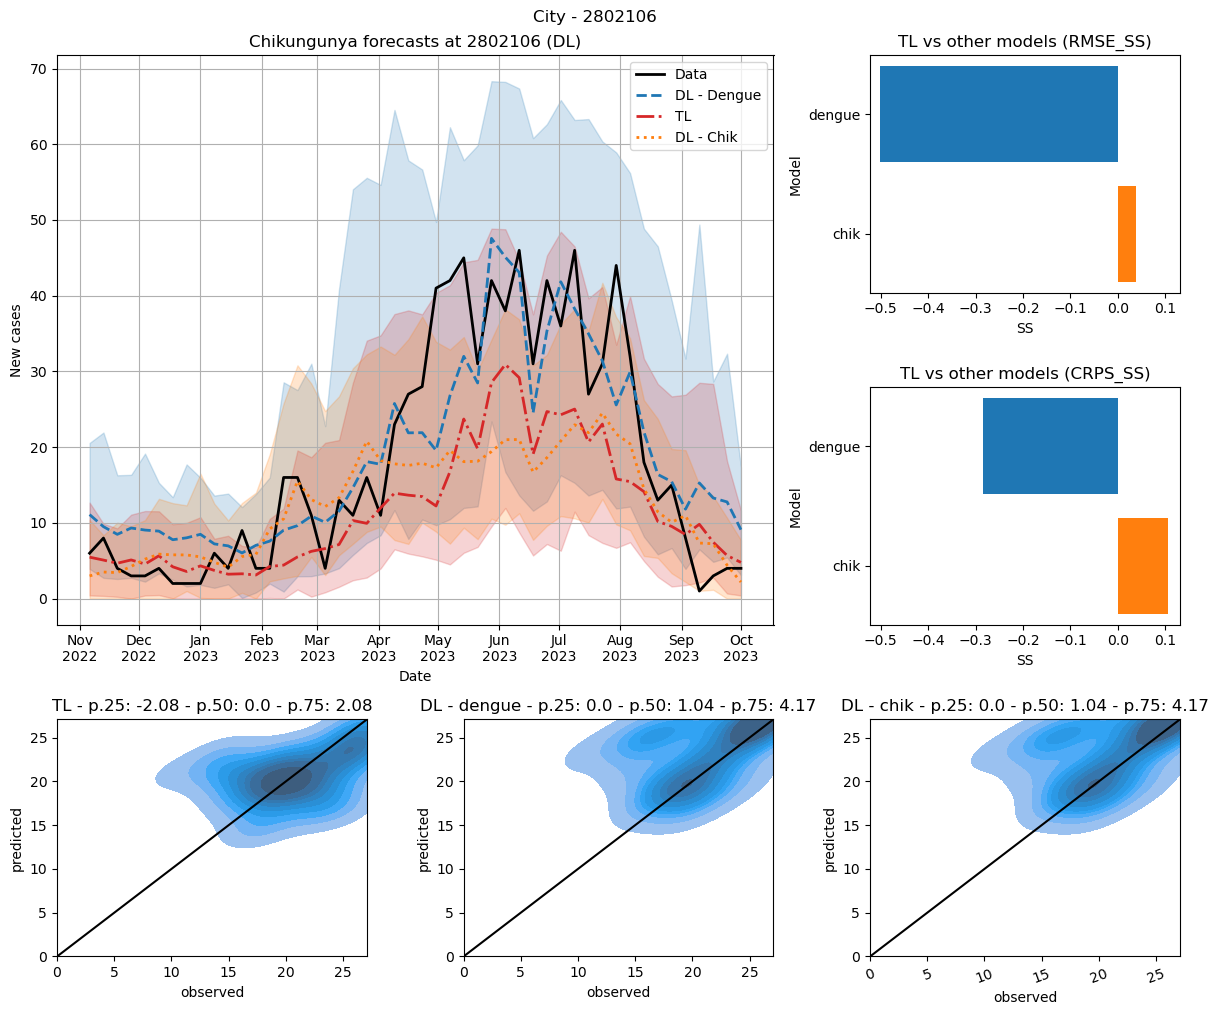

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


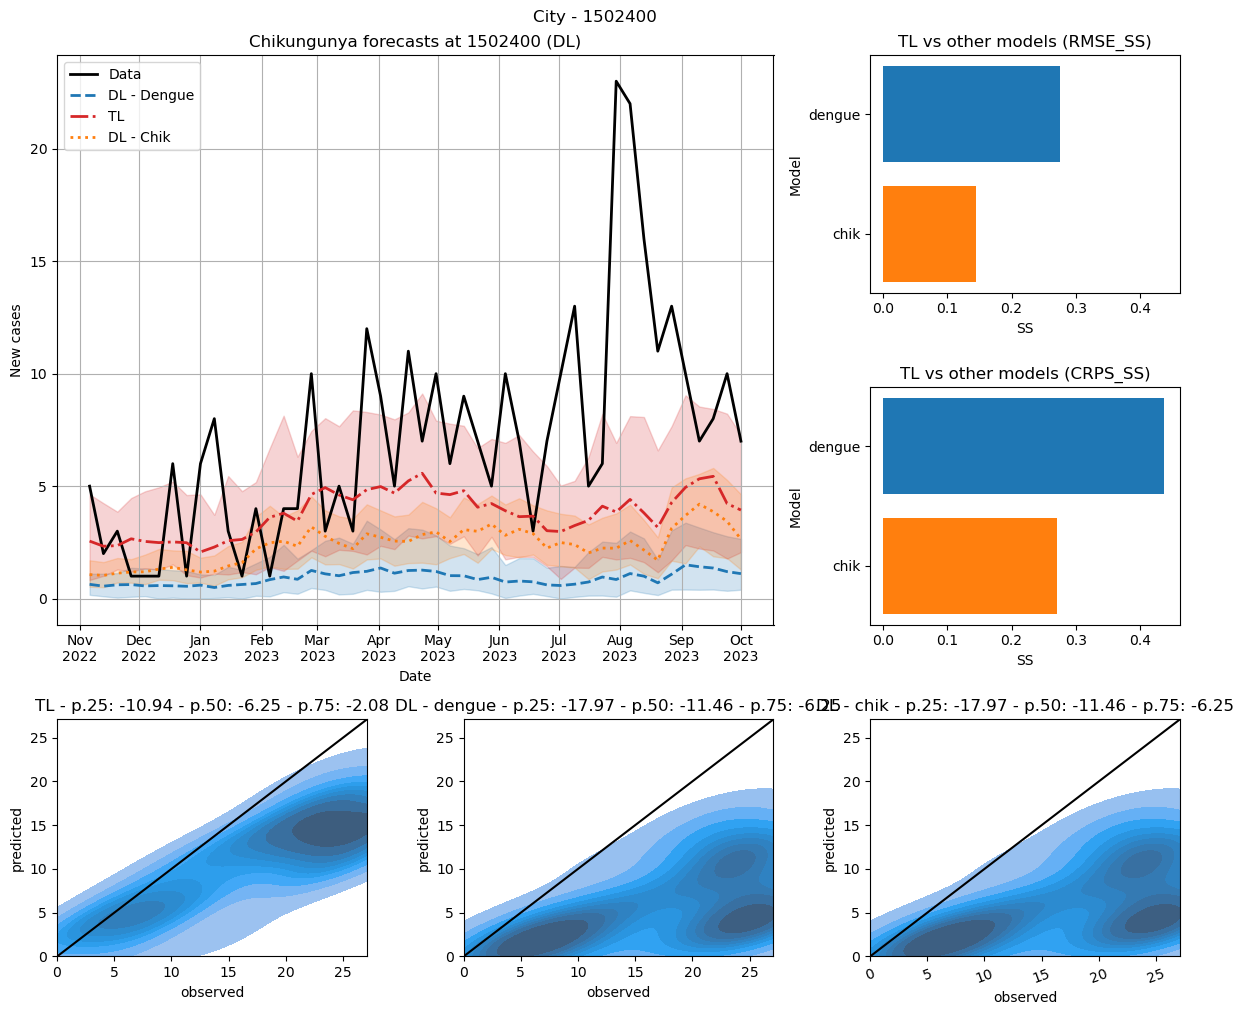

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


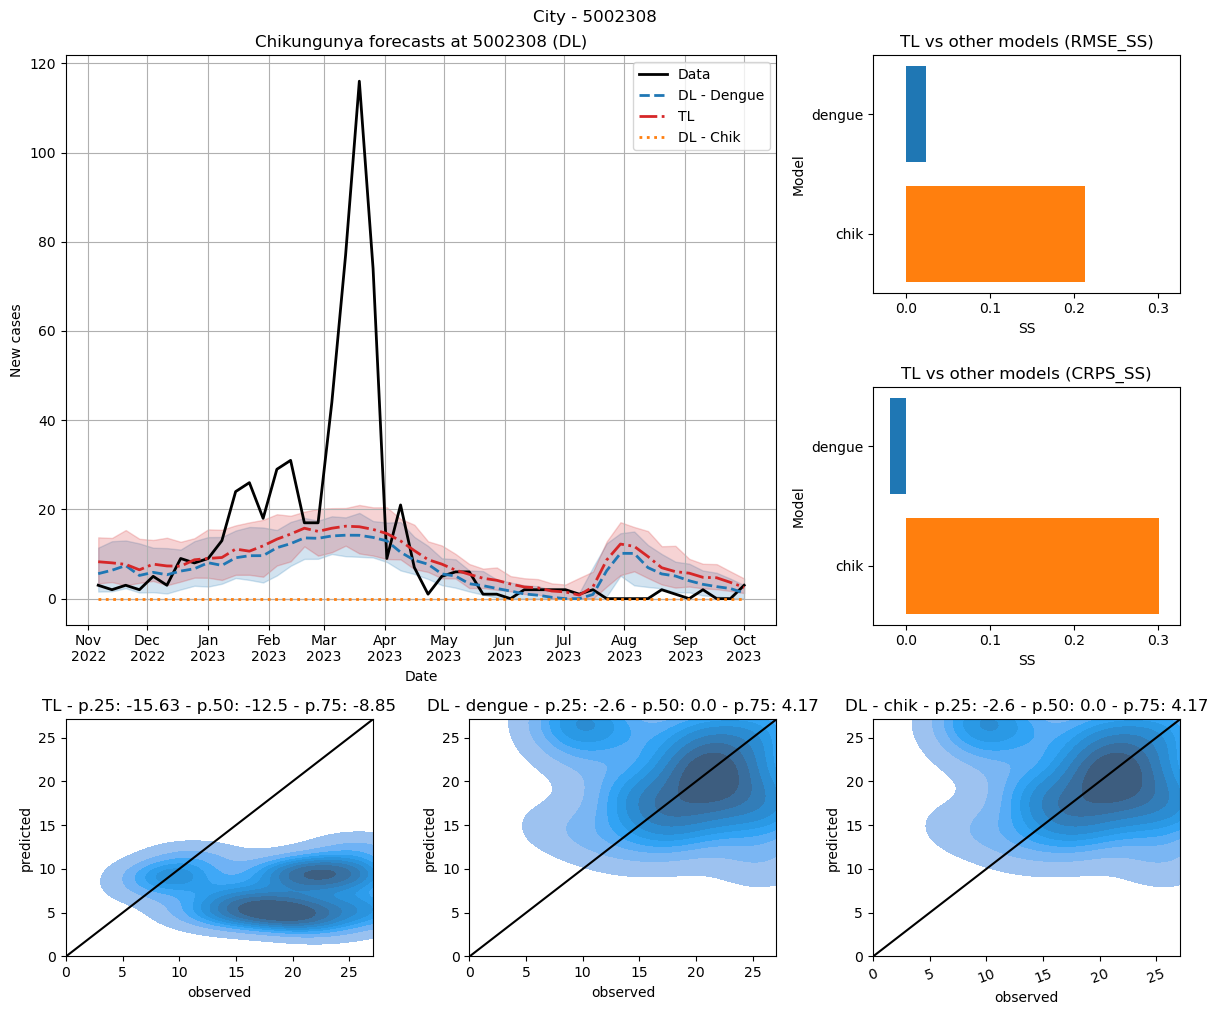

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


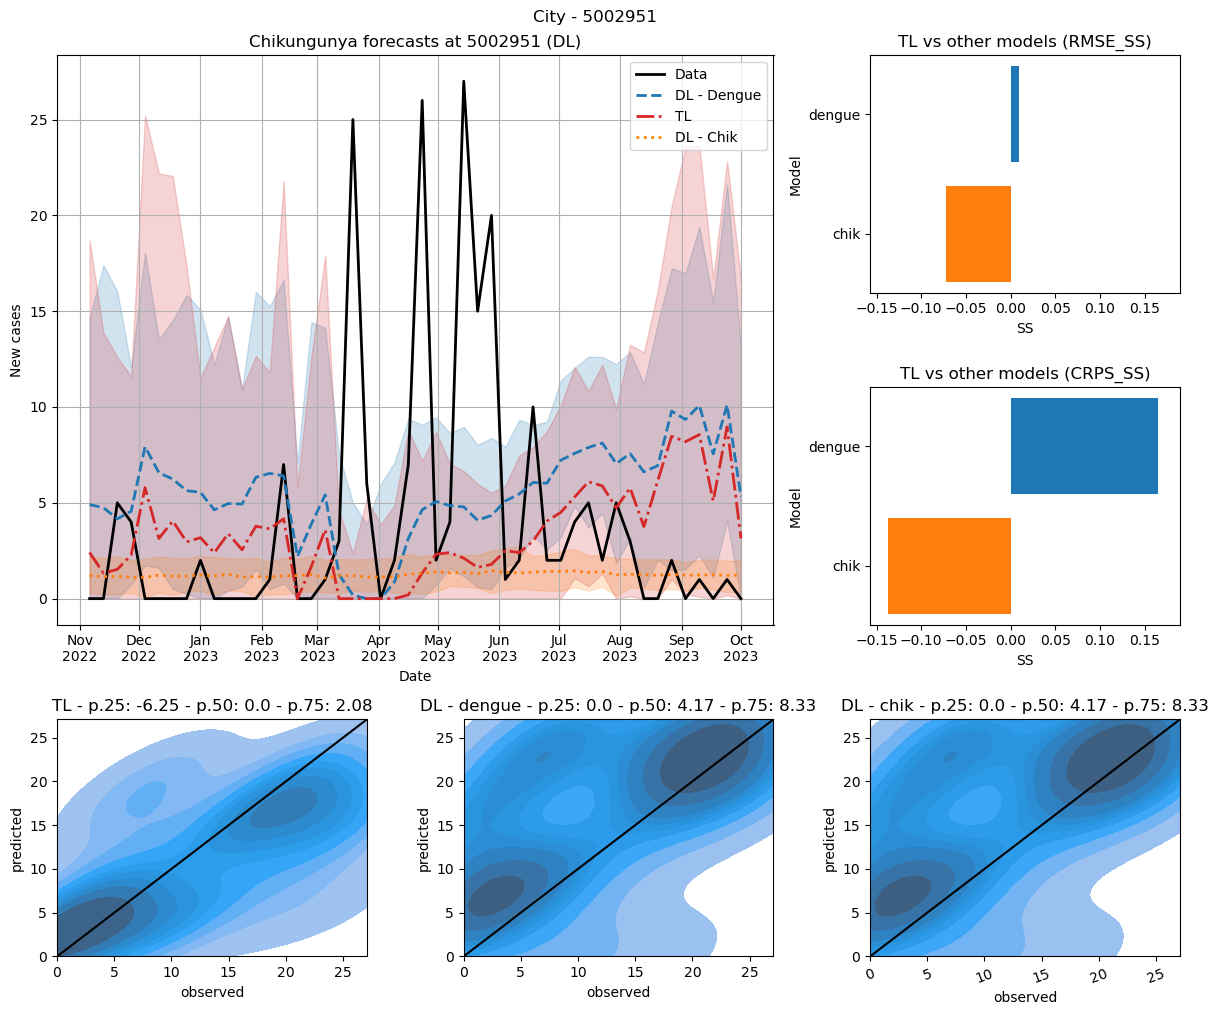

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


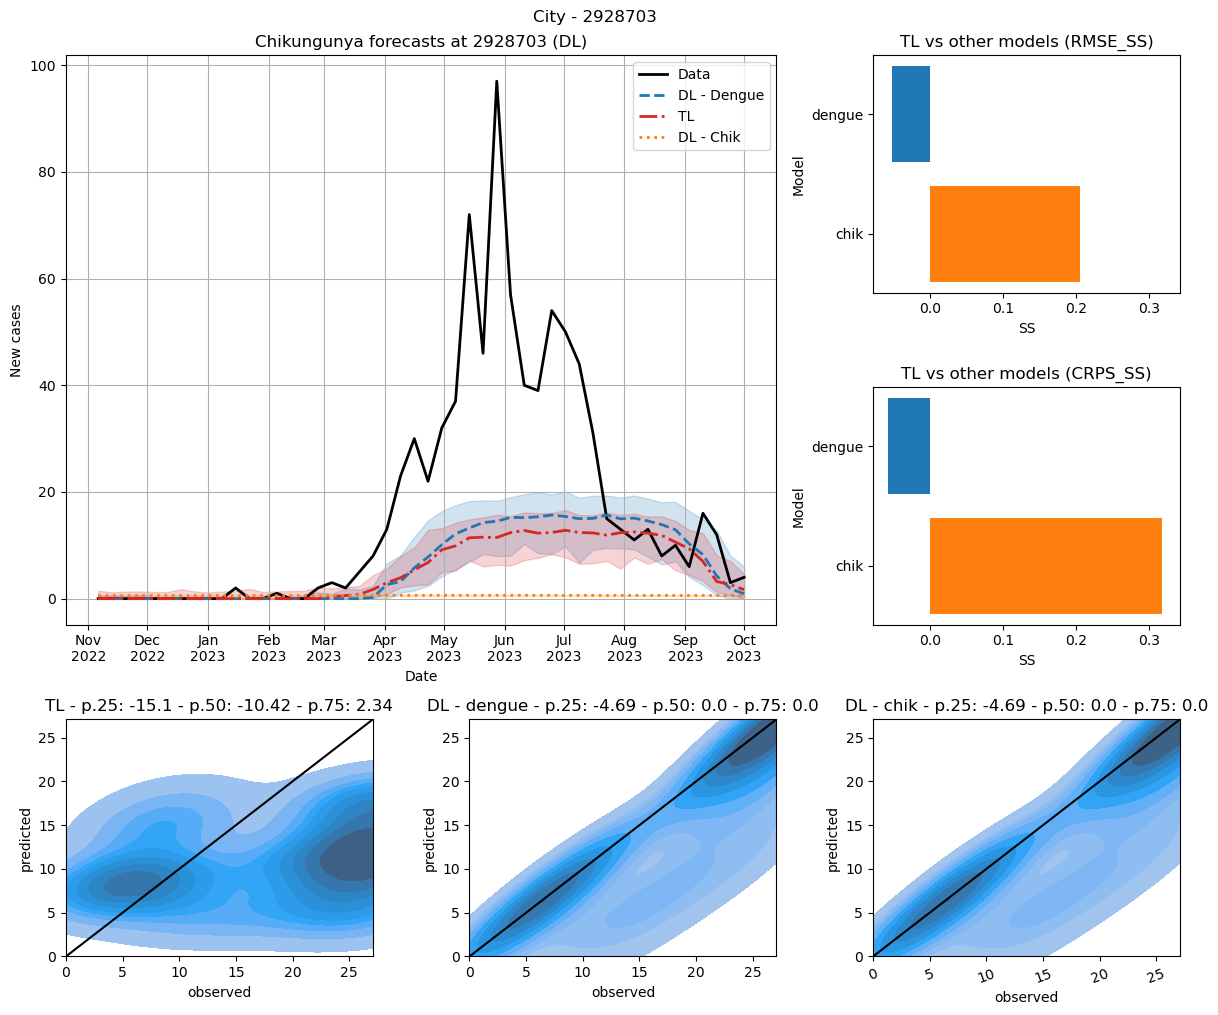

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


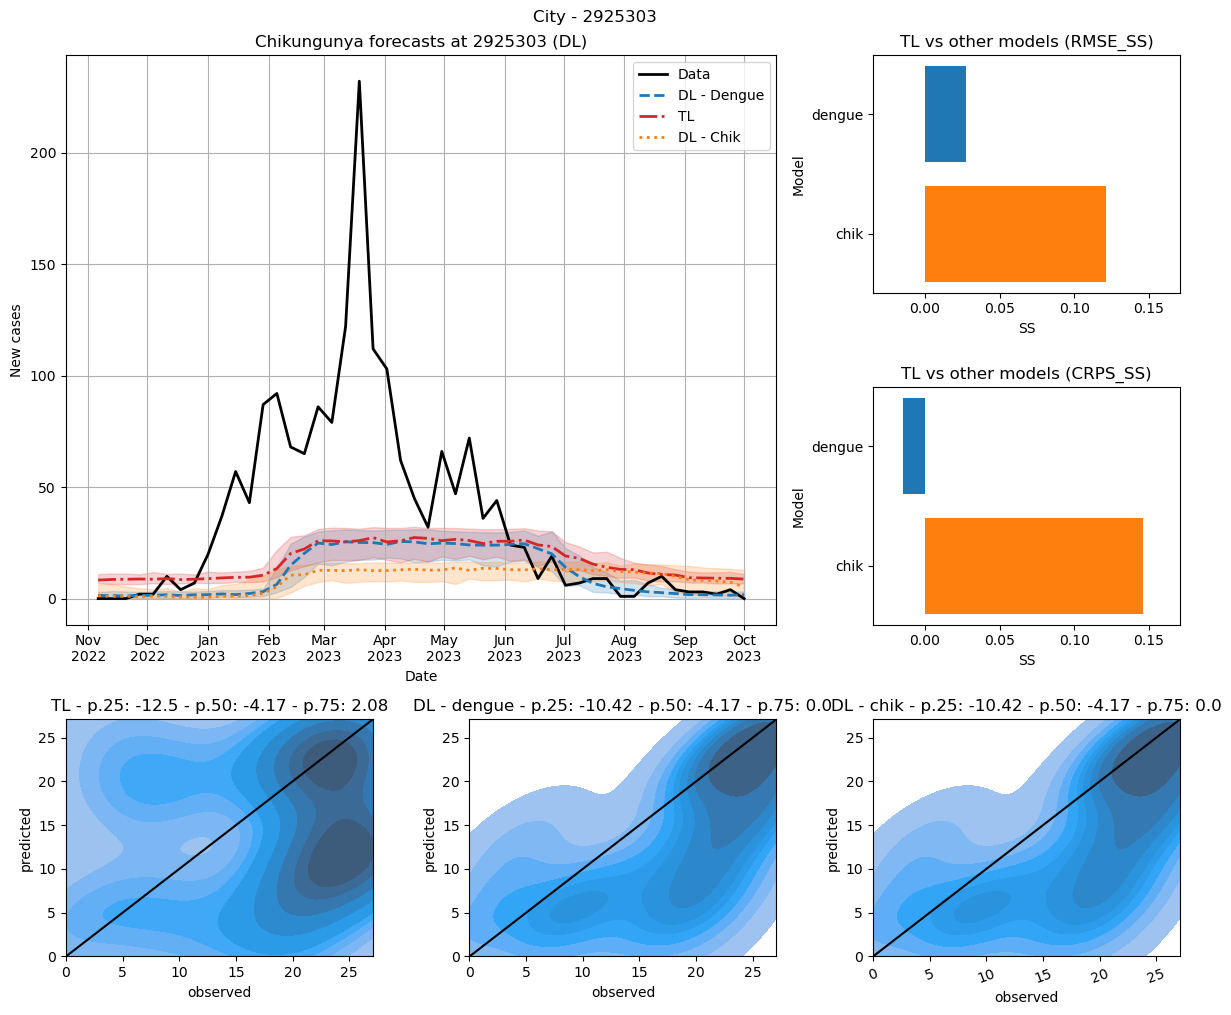

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


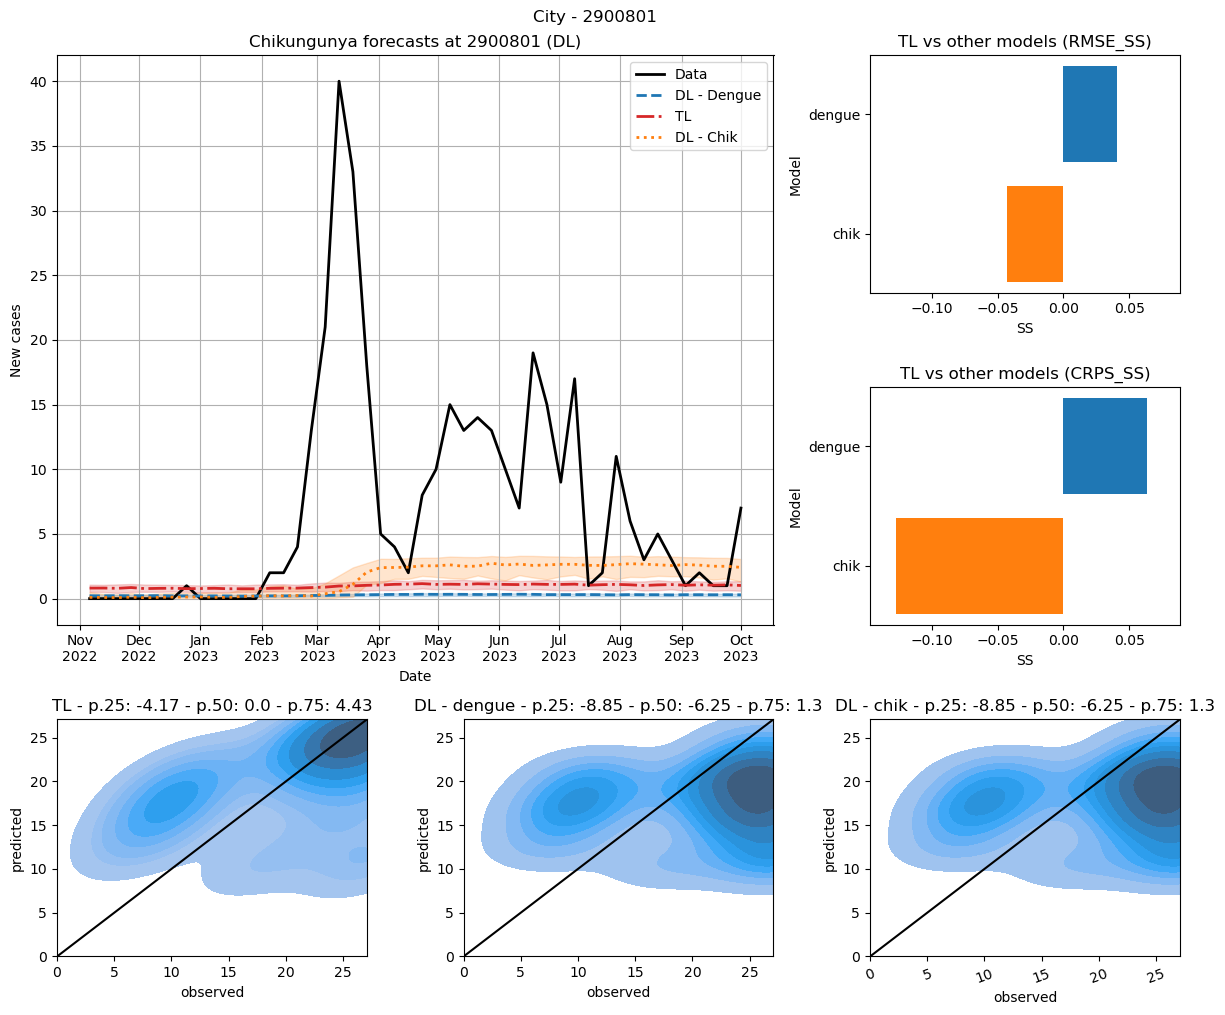

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


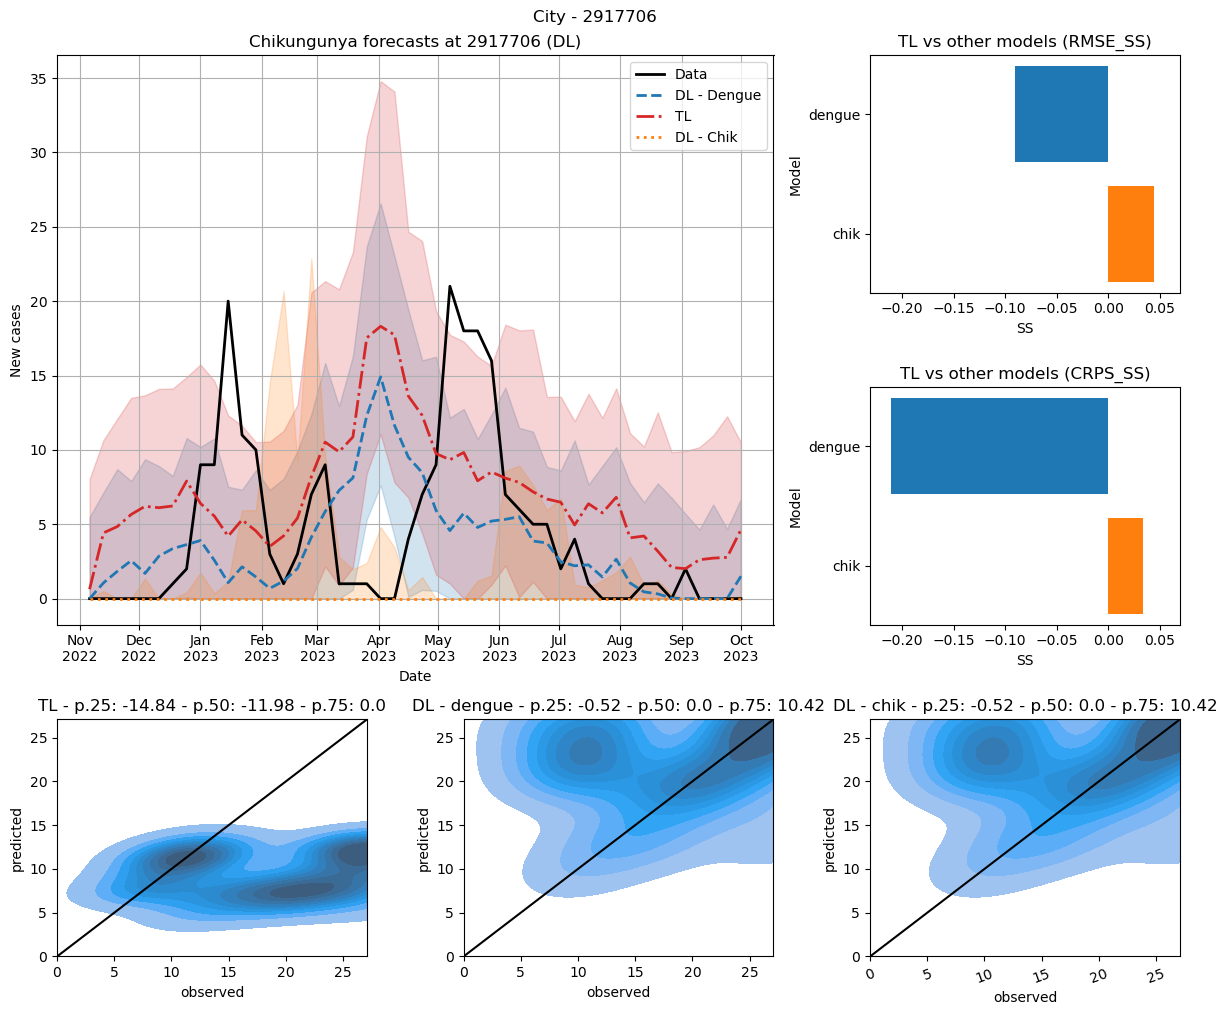

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_12727/324150814.py:108: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


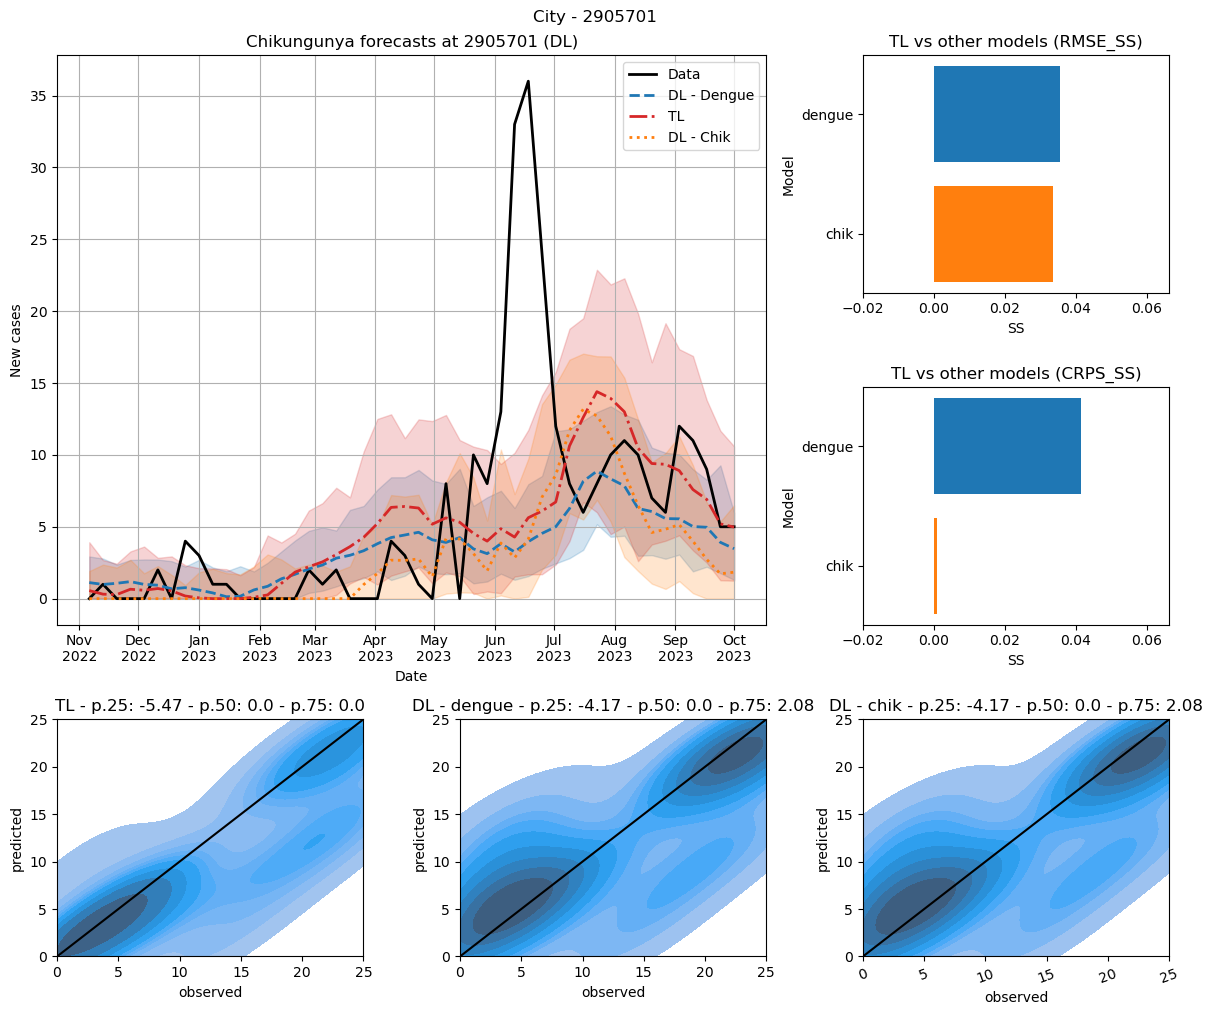

In [18]:
df = pd.read_csv('s_cities.csv',index_col = 'Unnamed: 0')

df = df.loc[~df.geocode.isin([3135050, 3143302, 1716109, 3304102, 3141405, 2905008, 29005008])]

ini_evaluate = '2022-11-01'
end_evaluate = '2023-10-01'

for city in df.geocode:
    
    gen_summary(city, ini_evaluate, end_evaluate)